# Semantic segmentation of aerial images with deep networks

This notebook presents a straightforward PyTorch implementation of a Fully Convolutional Network for semantic segmentation of aerial images. More specifically, we aim to automatically perform scene interpretation of images taken from a plane or a satellite by classifying every pixel into several land cover classes.

As a demonstration, we are going to use the [SegNet architecture](http://mi.eng.cam.ac.uk/projects/segnet/) to segment aerial images over the cities of Vaihingen and Potsdam. The images are from the [ISPRS 2D Semantic Labeling dataset](http://www2.isprs.org/commissions/comm3/wg4/results.html). We will train a network to segment roads, buildings, vegetation and cars.

This work is a PyTorch implementation of the baseline presented in ["Beyond RGB: Very High Resolution Urban Remote Sensing With Multimodal Deep Networks "](https://hal.archives-ouvertes.fr/hal-01636145), *Nicolas Audebert*, *Bertrand Le Saux* and *Sébastien Lefèvre*, ISPRS Journal, 2018.

## Requirements

This notebook requires a few useful libraries, e.g. `torch`, `scikit-image`, `numpy` and `matplotlib`. You can install everything using `pip install -r requirements.txt`.

This is expected to run on GPU, and therefore you should use `torch` in combination with CUDA/cuDNN. This can probably be made to run on CPU but be warned that:
  * you have to remove all calls to `torch.Tensor.cuda()` throughout this notebook,
  * this will be very slow.
  
A "small" GPU should be enough, e.g. this runs fine on a 4.7GB Tesla K20m. It uses quite a lot of RAM as the dataset is stored in-memory (about 5GB for Vaihingen). You can spare some memory by disabling the caching below. 4GB should be more than enough without caching.

In [1]:
# imports and stuff
import numpy as np
from skimage import io
from glob import glob
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import os

import random
import itertools
# Matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
# Torch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
import torch.optim.lr_scheduler
import torch.nn.init
from torch.autograd import Variable
import psutil
import timeit

print('Start ! ')
print ("Memory usage: " + str(psutil.virtual_memory().percent))

Start ! 
Memory usage: 56.3


## Parameters

There are several parameters than can be tuned to use this notebook with different datasets. The default parameters are suitable for the ISPRS dataset, but you can change them to work with your data.

### Examples

  * Binary classification: `N_CLASSES = 2`
  * Multi-spectral data (e.g. IRRGB): `IN_CHANNELS = 4`
  * New folder naming convention : `DATA_FOLDER = MAIN_FOLDER + 'sentinel2/sentinel2_img_{}.tif'`

In [18]:
# Parameters
patch_width = 256
tile_width = 5000

#Memory_tiles = 80  # how many tiles can be stored in CPU memeory
#number_tiles_in_memory = 0 # 
#Intervals = [] # If total tiles = 142, Memory_tiles = 40, the Intervals = [40, 80, 120, 142]
#number_tiles = 0 # number of total tiles
#start_tile_id = 1
#end_tile_id = number_tiles_in_memory

Memory_usage = 90

#data_extension = '.TIF'
#label_extension = '.tif'

WINDOW_SIZE = (patch_width, patch_width) # Patch size

patch_number_image = (int(tile_width / patch_width) + 1) ** 2  
number_sample = 0 # will = patch_number_image * len(all_ids), number of samples of each epoch

STRIDE = 32 # Stride for testing
IN_CHANNELS = 4 # Number of input channels (e.g. RGB)
FOLDER = r"D:\Dataset\ISPRS" # Replace with your "/path/to/the/ISPRS/dataset/folder/"
BATCH_SIZE = 1 # Number of samples in a mini-batch
TEST_BATCH_SIZE = 30

#LABELS = ["roads", "buildings", "low veg.", "trees", "cars", "clutter"] # Label names
#LABELS = ["0000", "0601", "0610", "0521", "0750", "0311", "0411", "0511", "1001", "0250", "0340", "0360", "0710", "0422", "0890", "0830", "0312", "0110", "0313", "0120", "0550", "0321", "0424", "0211", "0291", "0721", "0810", "0540", "0330", "0522", "0212", "0770", "0790", "1012", "0760", "0530", "0230", "0370", "0920", "0220", "0822", "0821", "0950", "0293", "0930"]
#LABELS = ["00", "06", "05", "07", "03", "04", "10", "02", "99", "01", "08", "09"]
LABELS = ["00", "Road", "Housing area", "Structure", "Forest", "Grass", "Water", "Orchard", "Ignored", "Cropland", "Excavated", "Bareland"]
LABELS = ['Background', 'Sidewalk']
print(LABELS)

#Labels for confusion matrix "8" is the ignored changed area
Label_values = [0, 1]


N_CLASSES = len(LABELS) # Number of classes
#WEIGHTS = torch.ones(N_CLASSES) # Weights for class balancing
# huan
#WEIGHTS = torch.FloatTensor([0, 0.044289626, 0.01262308, 0.092527621, 0.001295222, 0.010091334, 0.011178817, 0.023869527, 0.036896865, 0.001978375, 1])
WEIGHTS = torch.FloatTensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1])
WEIGHTS = torch.FloatTensor([1, 5])

#WEIGHTS = WEIGHTS * 100

print('WEIGHTS')
print(WEIGHTS)
CACHE = True # Store the dataset in-memory
#CACHE = False
print('N_CLASSES')
print(N_CLASSES)

print('patch_number_image')
print(patch_number_image)

image_cache = []
label_cache = []

DATASET = 'Potsdam'

if DATASET == 'Potsdam':
    MAIN_FOLDER = FOLDER + 'Potsdam/'
    DATA_FOLDER = MAIN_FOLDER + 'Y_Ortho_IRRG/top_potsdam_{}_IRRG.tif'
    LABEL_FOLDER = MAIN_FOLDER + '5_Labels_for_participants/top_potsdam_{}_label.tif'
    ERODED_FOLDER = MAIN_FOLDER + '5_Labels_for_participants_no_Boundary/top_potsdam_{}_label_noBoundary.tif'    
elif DATASET == 'Vaihingen':
    MAIN_FOLDER = FOLDER + 'Vaihingen/'
    DATA_FOLDER = MAIN_FOLDER + 'top/top_mosaic_09cm_area{}.tif'
    LABEL_FOLDER = MAIN_FOLDER + 'gts_for_participants/top_mosaic_09cm_area{}.tif'
    ERODED_FOLDER = MAIN_FOLDER + 'gts_eroded_for_participants/top_mosaic_09cm_area{}_noBoundary.tif'
    
#FOLDER = r"D:\Dataset"
#MAIN_FOLDER = os.path.join(FOLDER, 'DX')
DATA_FOLDER = r'I:\NewYorkCity_sidewalks\Images\{}.TIF'
LABEL_FOLDER = r'I:\NewYorkCity_sidewalks\sidewalks\{}.tif'
#ERODED_FOLDER = MAIN_FOLDER + '\RemovedTag5\C1\{}.tif'
    

['Background', 'Sidewalk']
WEIGHTS
tensor([1., 5.])
N_CLASSES
2
patch_number_image
400


## Visualizing the dataset

First, let's check that we are able to access the dataset and see what's going on. We use ```scikit-image``` for image manipulation.

As the ISPRS dataset is stored with a ground truth in the RGB format, we need to define the color palette that can map the label id to its RGB color. We define two helper functions to convert from numeric to colors and vice-versa.

invert_palette:
{(255, 255, 255): 12, (165, 165, 165): 1, (255, 0, 0): 2, (171, 93, 160): 3, (84, 130, 53): 4, (226, 240, 217): 5, (91, 155, 213): 6, (169, 209, 142): 7, (255, 230, 153): 9, (158, 72, 14): 10, (99, 99, 99): 11}


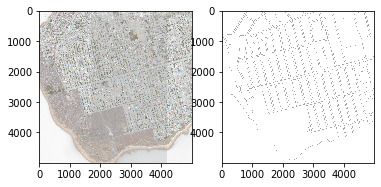

Ground truth in numerical format has shape (5000,5000e) : 
 [[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


In [3]:
# ISPRS color palette
# Let's define the standard ISPRS color palette
palette = { # Impervious surfaces (white)
           0 : (255,255,255),
           1 : (165,165,165),     # Road
           2 : (255,0,0),   #  Building
           3 : (171,93,160),     # Structure
           4 : (84,130,53),   #  Forest
           5 : (226,240,217),     # Grass
           6 : (91,155,213),   # Water
           7 : (169,209,142),  # Garden
           8 : (255, 255, 255),  # Ignore
           9 : (255,230,153),    # Farmland
           10 : (158,72,14),      # Excavated
           11 : (99,99,99),        # Bared
           12 : (255, 255, 255)
          }       
#
 

invert_palette = {v: k for k, v in palette.items()}

print('invert_palette:')
print(invert_palette)

def convert_to_color(arr_2d, palette=palette):
    """ Numeric labels to RGB-color encoding """
    arr_3d = np.zeros((arr_2d.shape[0], arr_2d.shape[1], 3), dtype=np.uint8)

    for c, i in palette.items():
        m = arr_2d == c
        arr_3d[m] = i

    return arr_3d

def convert_from_color(arr_3d, palette=invert_palette):
    """ RGB-color encoding to grayscale labels """
    arr_2d = np.zeros((arr_3d.shape[0], arr_3d.shape[1]), dtype=np.uint8)

    for c, i in palette.items():
        m = np.all(arr_3d == np.array(c).reshape(1, 1, 3), axis=2)
        arr_2d[m] = i

    return arr_2d

# We load one tile from the dataset and we display it
img = io.imread(r'I:\NewYorkCity_sidewalks\Images\0.TIF')
fig = plt.figure()
fig.add_subplot(121)
plt.imshow(img)

# We load the ground truth
gt = io.imread(r'I:\NewYorkCity_sidewalks\sidewalks\0.tif')
gt_c = convert_to_color(gt)
fig.add_subplot(122)
plt.imshow(gt_c)
plt.show()

# We also check that we can convert the ground truth into an array format
# huan array_gt = convert_from_color(gt)
array_gt = gt
print("Ground truth in numerical format has shape ({},{}e) : \n".format(*array_gt.shape[:2]), array_gt)

We need to define a bunch of utils functions.

In [4]:
# Utils

def get_random_pos(img, window_shape):
    w, h = window_shape
    W, H = img.shape[-2:]
    x1 = random.randint(0, W - w - 1)
    x2 = x1 + w
    y1 = random.randint(0, H - h - 1)
    y2 = y1 + h
    return x1, x2, y1, y2

def CrossEntropy2d(input, target, weight=None, size_average=True):
    # huan
    #print('input: ')
    #print(input)
    
    #print('target: ')
    #print(target)
    
    
    """ 2D version of the cross entropy loss """
    dim = input.dim()
    if dim == 2:
        return F.cross_entropy(input, target, weight, size_average)
        #print('dim: ')
        #print(dim)
    elif dim == 4:
        output = input.view(input.size(0),input.size(1), -1)
        output = torch.transpose(output,1,2).contiguous()
        output = output.view(-1,output.size(2))
        target = target.view(-1)
        
        #print('input.size: {}, {}'.format(input.size(0), input.size(1)))
        
        #print('target: ')
        #print(target)
        
        
        #print('output: ')
        #print(output)
        
        
        return F.cross_entropy(output, target,weight, size_average)
    else:
        raise ValueError('Expected 2 or 4 dimensions (got {})'.format(dim))

def accuracy(input, target):
    return 100 * float(np.count_nonzero(input == target)) / target.size

def sliding_window(top, step=10, window_size=(20,20)):
    """ Slide a window_shape window across the image with a stride of step """
    for x in range(0, top.shape[0], step):
        if x + window_size[0] > top.shape[0]:
            x = top.shape[0] - window_size[0]
        for y in range(0, top.shape[1], step):
            if y + window_size[1] > top.shape[1]:
                y = top.shape[1] - window_size[1]
            yield x, y, window_size[0], window_size[1]
            
def count_sliding_window(top, step=10, window_size=(20,20)):
    """ Count the number of windows in an image """
    c = 0
    for x in range(0, top.shape[0], step):
        if x + window_size[0] > top.shape[0]:
            x = top.shape[0] - window_size[0]
        for y in range(0, top.shape[1], step):
            if y + window_size[1] > top.shape[1]:
                y = top.shape[1] - window_size[1]
            c += 1
    return c

def grouper(n, iterable):
    """ Browse an iterator by chunk of n elements """
    it = iter(iterable)
    while True:
        chunk = tuple(itertools.islice(it, n))
        if not chunk:
            return
        yield chunk

def metrics(predictions, gts, label_values, report_path):
    print('range(len(gts))')
    print(range(len(gts)))
    
    print('range(len(predictions))')
    print(range(len(predictions)))
    
    print('range(len(label_values))')
    print(range(len(label_values)))
    
    #report = open(MAIN_FOLDER + 'Test_all_report_100tiles_QS.txt', 'w')
    report = open(report_path, 'w')
    report.writelines('Train ids: ' + str("Confusion matrix :\n"))
    
    cm = confusion_matrix(gts, predictions, label_values)
    
    f1 = f1_score(gts, predictions, average='micro')
    print("F1_score:  micro")
    print(f1)
    
    f1 = f1_score(gts, predictions, average='macro')
    print("F1_score:  macro")
    print(f1)
    
    f1 = f1_score(gts, predictions, average=None)
    print("F1_score: None")
    print(f1)
    
#     accur = accuracy_score(gts, predictions)
#     print("accuracy_score:  ")
#     print(accur)
        
#     rpt = classification_report(gts, predictions, LABELS)
#     print("classification_report:  ")
#     print(accur)    
    
    
    print("Confusion matrix :")
    report.writelines(str("Confusion matrix : \n"))
    print(cm)
    report.writelines(str(cm) +'\n')
    report.writelines('----------- \n ')
    
    print("---")
    
    # Compute global accuracy
    total = sum(sum(cm))
    accuracy = sum([cm[x][x] for x in range(len(cm))])
    accuracy *= 100 / float(total)
    print("{} pixels processed".format(total))
    print("Total accuracy : {}%".format(accuracy))
    
    print("---")
    
    report.writelines("{} pixels processed \n".format(total))
    report.writelines("Total accuracy : {}% \n".format(accuracy))
    report.writelines("---\n")
    
    # Compute F1 score
    F1Score = np.zeros(len(label_values))
    class_accuracy = np.zeros(len(label_values))
    class_recall = np.zeros(len(label_values))
    for i in range(len(label_values)):
        try:
            F1Score[i] = 2. * cm[i,i] / (np.sum(cm[i,:]) + np.sum(cm[:,i]))
            class_accuracy[i] =  cm[i,i] / np.sum(cm[:,i])
            class_recall[i] = cm[i,i] / np.sum(cm[i,:])
        except:
            # Ignore exception if there is no element in class i for test set
            pass
        
    report.writelines("F1Score : \n")    
    print("F1Score :")
    
    
    for l_id, score in enumerate(F1Score):
        print("{}: {}".format(LABELS[label_values[l_id]], score))
        report.writelines("{}: {} \n".format(LABELS[label_values[l_id]], score))
    print("---")
    
    print("class_accuracy :") 
    report.writelines("\n class_accuracy : \n")  
    for l_id, score in enumerate(class_accuracy):
        print("{}: {}".format(LABELS[label_values[l_id]], score))
        report.writelines("{}: {} \n".format(LABELS[label_values[l_id]], score))
    print("---")

    print("class_recall :") 
    report.writelines("\n class_recall : \n")  
    for l_id, score in enumerate(class_recall):
        print("{}: {}".format(LABELS[label_values[l_id]], score))
        report.writelines("{}: {} \n".format(LABELS[label_values[l_id]], score))
    print("---")

    print("\nClass summary :") 
    report.writelines("\nClass summary :\n")
    for i in range(len(label_values)):
        print('Correct, Ground truth, Predict: ', LABELS[label_values[i]], cm[i,i], np.sum(cm[i,:]),np.sum(cm[:,i]))
        report.writelines('Correct, Ground truth, Predict: {}: {}, {}, {}\n'.format(LABELS[label_values[i]], cm[i,i], np.sum(cm[i,:]), np.sum(cm[:,i])))
        
    
    report.writelines("---\n")
    
        
    # Compute kappa coefficient
    total = np.sum(cm)
    pa = np.trace(cm) / float(total)
    pe = np.sum(np.sum(cm, axis=0) * np.sum(cm, axis=1)) / float(total*total)
    kappa = (pa - pe) / (1 - pe);
    print("Kappa: " + str(kappa))
    
    report.writelines("Kappa: " + str(kappa) +'\n')
    
    report.close()
    
    return accuracy

## Loading the dataset

We define a PyTorch dataset (```torch.utils.data.Dataset```) that loads all the tiles in memory and performs random sampling. Tiles are stored in memory on the fly.

The dataset also performs random data augmentation (horizontal and vertical flips) and normalizes the data in [0, 1].

In [5]:
# Dataset class

class RS_dataset(torch.utils.data.Dataset):
    def __init__(self, image_cache, label_cache, augmentation=True):
        super(RS_dataset, self).__init__()
        
        self.augmentation = augmentation
         
        
        # List of files
        #self.data_files = [DATA_FOLDER.format(id) for id in ids]
        #self.label_files = [LABEL_FOLDER.format(id) for id in ids]

        # Sanity check : raise an error if some files do not exist
#         for f in self.data_files + self.label_files:
#             if not os.path.isfile(f):
#                 raise KeyError('{} is not a file !'.format(f))
        
#         # Initialize cache dicts
#         #if self.cache:
#         self.image_dic = []
#         self.label_dic = []
#             
    
    def __len__(self):
        # Default epoch size is 10 000 samples
        return number_sample  
    
    @classmethod
    def data_augmentation(cls, *arrays, flip=True, mirror=True):
        will_flip, will_mirror = False, False
        if flip and random.random() < 0.5:
            will_flip = True
        if mirror and random.random() < 0.5:
            will_mirror = True
        
        results = []
        for array in arrays:
            if will_flip:
                if len(array.shape) == 2:
                    array = array[::-1, :]
                else:
                    array = array[:, ::-1, :]
            if will_mirror:
                if len(array.shape) == 2:
                    array = array[:, ::-1]
                else:
                    array = array[:, :, ::-1]
            results.append(np.copy(array))
            
        return tuple(results)
    
    def __getitem__(self, i):
        # Pick a random image
        random_idx = random.randint(0, len(image_cache) - 1)
        
        # If the tile hasn't been loaded yet, put in cache
#         if random_idx in self.data_cache_.keys():
#             data = self.data_cache_[random_idx]
#         else:
            # Data is normalized in [0, 1]
        data = image_cache[random_idx]
#             if self.cache:
#                 self.data_cache_[random_idx] = data
            
#         if random_idx in self.label_cache_.keys():
        label = label_cache[random_idx]
#         else: 
#             # Labels are converted from RGB to their numeric values
#             # huan label = np.asarray(convert_from_color(io.imread(self.label_files[random_idx])), dtype='int64')
#             label = np.asarray(io.imread(self.label_files[random_idx]), dtype='int64')
#             #huan
#             #print(label)
#             if self.cache:
#                 self.label_cache_[random_idx] = label

        # Get a random patch
        x1, x2, y1, y2 = get_random_pos(data, WINDOW_SIZE)
        data_p = data[:, x1:x2,y1:y2]
        label_p = label[x1:x2,y1:y2]
        
        # Data augmentation
        data_p, label_p = self.data_augmentation(data_p, label_p)

        # Return the torch.Tensor values
        return (torch.from_numpy(data_p),
                torch.from_numpy(label_p))

## Network definition

We can now define the Fully Convolutional network based on the SegNet architecture. We could use any other network as drop-in replacement, provided that the output has dimensions `(N_CLASSES, W, H)` where `W` and `H` are the sliding window dimensions (i.e. the network should preserve the spatial dimensions).

In [6]:
class SegNet(nn.Module):
    # SegNet network
    @staticmethod
    def weight_init(m):
        if isinstance(m, nn.Linear):
            torch.nn.init.kaiming_normal(m.weight.data)
    
    def __init__(self, in_channels=IN_CHANNELS, out_channels=N_CLASSES):
        super(SegNet, self).__init__()
        self.pool = nn.MaxPool2d(2, return_indices=True)
        self.unpool = nn.MaxUnpool2d(2)
        
        self.conv1_1 = nn.Conv2d(in_channels, 64, 3, padding=1)
        self.conv1_1_bn = nn.BatchNorm2d(64)
        self.conv1_2 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv1_2_bn = nn.BatchNorm2d(64)
        
        self.conv2_1 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv2_1_bn = nn.BatchNorm2d(128)
        self.conv2_2 = nn.Conv2d(128, 128, 3, padding=1)
        self.conv2_2_bn = nn.BatchNorm2d(128)
        
        self.conv3_1 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv3_1_bn = nn.BatchNorm2d(256)
        self.conv3_2 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv3_2_bn = nn.BatchNorm2d(256)
        self.conv3_3 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv3_3_bn = nn.BatchNorm2d(256)
        
        self.conv4_1 = nn.Conv2d(256, 512, 3, padding=1)
        self.conv4_1_bn = nn.BatchNorm2d(512)
        self.conv4_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv4_2_bn = nn.BatchNorm2d(512)
        self.conv4_3 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv4_3_bn = nn.BatchNorm2d(512)
        
        self.conv5_1 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_1_bn = nn.BatchNorm2d(512)
        self.conv5_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_2_bn = nn.BatchNorm2d(512)
        self.conv5_3 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_3_bn = nn.BatchNorm2d(512)
        
        self.conv5_3_D = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_3_D_bn = nn.BatchNorm2d(512)
        self.conv5_2_D = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_2_D_bn = nn.BatchNorm2d(512)
        self.conv5_1_D = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_1_D_bn = nn.BatchNorm2d(512)
        
        self.conv4_3_D = nn.Conv2d(512, 512, 3, padding=1)
        self.conv4_3_D_bn = nn.BatchNorm2d(512)
        self.conv4_2_D = nn.Conv2d(512, 512, 3, padding=1)
        self.conv4_2_D_bn = nn.BatchNorm2d(512)
        self.conv4_1_D = nn.Conv2d(512, 256, 3, padding=1)
        self.conv4_1_D_bn = nn.BatchNorm2d(256)
        
        self.conv3_3_D = nn.Conv2d(256, 256, 3, padding=1)
        self.conv3_3_D_bn = nn.BatchNorm2d(256)
        self.conv3_2_D = nn.Conv2d(256, 256, 3, padding=1)
        self.conv3_2_D_bn = nn.BatchNorm2d(256)
        self.conv3_1_D = nn.Conv2d(256, 128, 3, padding=1)
        self.conv3_1_D_bn = nn.BatchNorm2d(128)
        
        self.conv2_2_D = nn.Conv2d(128, 128, 3, padding=1)
        self.conv2_2_D_bn = nn.BatchNorm2d(128)
        self.conv2_1_D = nn.Conv2d(128, 64, 3, padding=1)
        self.conv2_1_D_bn = nn.BatchNorm2d(64)
        
        self.conv1_2_D = nn.Conv2d(64, 64, 3, padding=1)
        self.conv1_2_D_bn = nn.BatchNorm2d(64)
        self.conv1_1_D = nn.Conv2d(64, out_channels, 3, padding=1)
        
        self.apply(self.weight_init)
        
    def forward(self, x):
        # Encoder block 1
        x = self.conv1_1_bn(F.relu(self.conv1_1(x)))
        x = self.conv1_2_bn(F.relu(self.conv1_2(x)))
        x, mask1 = self.pool(x)
        
        # Encoder block 2
        x = self.conv2_1_bn(F.relu(self.conv2_1(x)))
        x = self.conv2_2_bn(F.relu(self.conv2_2(x)))
        x, mask2 = self.pool(x)
        
        # Encoder block 3
        x = self.conv3_1_bn(F.relu(self.conv3_1(x)))
        x = self.conv3_2_bn(F.relu(self.conv3_2(x)))
        x = self.conv3_3_bn(F.relu(self.conv3_3(x)))
        x, mask3 = self.pool(x)
        
        # Encoder block 4
        x = self.conv4_1_bn(F.relu(self.conv4_1(x)))
        x = self.conv4_2_bn(F.relu(self.conv4_2(x)))
        x = self.conv4_3_bn(F.relu(self.conv4_3(x)))
        x, mask4 = self.pool(x)
        
        # Encoder block 5
        x = self.conv5_1_bn(F.relu(self.conv5_1(x)))
        x = self.conv5_2_bn(F.relu(self.conv5_2(x)))
        x = self.conv5_3_bn(F.relu(self.conv5_3(x)))
        x, mask5 = self.pool(x)
        
        # Decoder block 5
        x = self.unpool(x, mask5)
        x = self.conv5_3_D_bn(F.relu(self.conv5_3_D(x)))
        x = self.conv5_2_D_bn(F.relu(self.conv5_2_D(x)))
        x = self.conv5_1_D_bn(F.relu(self.conv5_1_D(x)))
        
        # Decoder block 4
        x = self.unpool(x, mask4)
        x = self.conv4_3_D_bn(F.relu(self.conv4_3_D(x)))
        x = self.conv4_2_D_bn(F.relu(self.conv4_2_D(x)))
        x = self.conv4_1_D_bn(F.relu(self.conv4_1_D(x)))
        
        # Decoder block 3
        x = self.unpool(x, mask3)
        x = self.conv3_3_D_bn(F.relu(self.conv3_3_D(x)))
        x = self.conv3_2_D_bn(F.relu(self.conv3_2_D(x)))
        x = self.conv3_1_D_bn(F.relu(self.conv3_1_D(x)))
        
        # Decoder block 2
        x = self.unpool(x, mask2)
        x = self.conv2_2_D_bn(F.relu(self.conv2_2_D(x)))
        x = self.conv2_1_D_bn(F.relu(self.conv2_1_D(x)))
        
        # Decoder block 1
        x = self.unpool(x, mask1)
        x = self.conv1_2_D_bn(F.relu(self.conv1_2_D(x)))
        x = F.log_softmax(self.conv1_1_D(x))
        return x
    
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )   


class UNet5layer(nn.Module):

    #def __init__(self, n_class):
    def __init__(self, in_channels=IN_CHANNELS, n_class=N_CLASSES):
        super().__init__()
                
        self.dconv_down1 = double_conv(in_channels, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)
        self.dconv_down5 = double_conv(512, 512)   # Huan  

        self.maxpool = nn.MaxPool2d(2)
        #self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
             
        self.dconv_up4 = double_conv(512 + 512, 512) # HUAN
        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
        
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        
        conv4 = self.dconv_down4(x)
        x = self.maxpool(conv4)   
        
        x = self.dconv_down5(x)
        
        #x = self.dconv_down5(x)        
        x = self.upsample(x)        
        x = torch.cat([x, conv4], dim=1)
        
        x = self.dconv_up4(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)               
        
        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   
        
        x = self.dconv_up1(x)
        
        out = self.conv_last(x)
        
        return out   

class UNet(nn.Module):

    def __init__(self, in_channels=IN_CHANNELS, n_class=N_CLASSES):
        super().__init__()
                
        self.dconv_down1 = double_conv(in_channels, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)        

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
        
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        
        x = self.dconv_down4(x)
        
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)
        
        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   
        
        x = self.dconv_up1(x)
        
        out = self.conv_last(x)
        
        return out

We can now instantiate the network using the specified parameters. By default, the weights will be initialized using the [He policy](https://www.cv-foundation.org/openaccess/content_iccv_2015/papers/He_Delving_Deep_into_ICCV_2015_paper.pdf).

In [7]:
# instantiate the network

#net1 = SegNet()
net1 = UNet()
#net = torch.nn.DataParallel(net1)
net = net1

cnt = sum(p.numel() for p in net.parameters() if p.requires_grad)
print('Number of Network Parameters: {}', cnt)

Number of Network Parameters: {} 7783554


We download and load the pre-trained weights from VGG-16 on ImageNet. This step is optional but it makes the network converge faster. We skip the weights from VGG-16 that have no counterpart in SegNet.

In [8]:
import os
import urllib

# Download VGG-16 weights from PyTorch
vgg_url = 'https://download.pytorch.org/models/vgg16_bn-6c64b313.pth'
# if not os.path.isfile('vgg16_bn-6c64b313.pth'):
#     #weights = urllib.URLopener()
#     weights = urllib.URLopener()
#     weights.retrieve(vgg_url, 'vgg16_bn-6c64b313.pth')

vgg16_weights = torch.load(r'I:\NewYorkCity_sidewalks\vgg16_bn-6c64b313.pth')
mapped_weights = {}
for k_vgg, k_segnet in zip(vgg16_weights.keys(), net.state_dict().keys()):
    if "features" in k_vgg:
        mapped_weights[k_segnet] = vgg16_weights[k_vgg]
        print("Mapping {} to {}".format(k_vgg, k_segnet))
        
try:
    net.load_state_dict(mapped_weights)
    print("Loaded VGG-16 weights in SegNet !")
except:
    # Ignore missing keys
    pass


net.load_state_dict(torch.load(r'unet256_5layer_epoch5_40tiles.pth'))

Mapping features.0.weight to dconv_down1.0.weight
Mapping features.0.bias to dconv_down1.0.bias
Mapping features.1.weight to dconv_down1.2.weight
Mapping features.1.bias to dconv_down1.2.bias
Mapping features.1.running_mean to dconv_down2.0.weight
Mapping features.1.running_var to dconv_down2.0.bias
Mapping features.3.weight to dconv_down2.2.weight
Mapping features.3.bias to dconv_down2.2.bias
Mapping features.4.weight to dconv_down3.0.weight
Mapping features.4.bias to dconv_down3.0.bias
Mapping features.4.running_mean to dconv_down3.2.weight
Mapping features.4.running_var to dconv_down3.2.bias
Mapping features.7.weight to dconv_down4.0.weight
Mapping features.7.bias to dconv_down4.0.bias
Mapping features.8.weight to dconv_down4.2.weight
Mapping features.8.bias to dconv_down4.2.bias
Mapping features.8.running_mean to dconv_up3.0.weight
Mapping features.8.running_var to dconv_up3.0.bias
Mapping features.10.weight to dconv_up3.2.weight
Mapping features.10.bias to dconv_up3.2.bias
Mapping

<All keys matched successfully>

Then, we load the network on GPU.

In [9]:
net.cuda()

UNet(
  (dconv_down1): Sequential(
    (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dconv_down2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dconv_down3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dconv_down4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kerne

### Loading the data

We now create a train/test split. If you want to use another dataset, you have to adjust the method to collect all filenames. In our case, we specify a fixed train/test split for the demo.

In [10]:
# Load the datasets
print("Loading data")
if DATASET == 'Potsdam':
    all_files = sorted(glob(LABEL_FOLDER.replace('{}', '*')))
    all_ids = ["_".join(f.split('_')[3:5]) for f in all_files]
    print('LABEL_FOLDER') # Huan
    print(LABEL_FOLDER)  # Huan
    print('all_files')  # huan
    #print(all_files)  # huan
    
    print('replace') # Huan
    print(LABEL_FOLDER.replace('{}', '*'))  # Huan
elif DATASET == 'Vaihingen':
    #all_ids = 
    all_files = sorted(glob(LABEL_FOLDER.replace('{}', '*')))
    print('LABEL_FOLDER') # Huan
    print(glob(LABEL_FOLDER.replace('{}', '*')))  # Huan
    print('all_files')  # huan
    print(all_files)  # huan
    print('replace') # Huan
    print(LABEL_FOLDER.replace('{}', '*'))  # Huan
    all_ids = [f.split('area')[-1].split('.')[0] for f in all_files]

all_files = sorted(glob(LABEL_FOLDER.replace('{}', '*')))
# print('LABEL_FOLDER') # Huan
# print(glob(LABEL_FOLDER.replace('{}', '*')))  # Huan
# print('all_files')  # huan
# print(all_files[0])  # huan
#print('replace') # Huan
#print(LABEL_FOLDER.replace('{}', '*'))  # Huan
all_ids = [f.split('/')[-1].split('.')[0] for f in all_files]

# huan
#print('all_ids')
#print(all_ids)

 

    
    
# Random tile numbers for train/test split
#print(all_ids) #Huan
print('len(all_ids)')  # Huan
print(len(all_ids)) 
number_tiles = len(all_ids) 

# train_ids = random.sample(all_ids, 2 * len(all_ids) // 3 + 1)
# test_ids = list(set(all_ids) - set(train_ids))

# # Exemple of a train/test split on Vaihingen :
# train_ids = ['1', '2','3', '23', '26', '7', '11', '13', '28', '17', '32', '34', '37']
# test_ids = ['5', '21', '15', '30'] 

# # Exemple of a train/test split on Potsdam :
# train_ids = ['2_10', '2_11', '2_12', '3_10', '3_11', '3_12', '4_10', '4_11', '4_12', '5_10', '5_11', '5_12', '6_7', '6_8','6_9', '6_10', '6_11', '6_12', '7_7', '7_8', '7_9', '7_10', '7_11', '7_12']
# test_ids = ['4_12', '7_7', '3_10', '5_10'] 
# test_ids = ['5_10'] 


# train_ids = ['65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '141', '142', '143', '144', '145', '146']
# test_ids = ['20', '60', '100', '140'] 


#train_ids = ['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','21','22','23','24','25','26','27','28','29','30','31','32','33','34','35','36','37','38','39','40','41','42','43','44','45','46','47','48','49','50','51','52','53','54','55','56','57','58','59','61','62','63','64','65','66','67','68','69','70','71','72','73','74','75','76','77','78','79','80','81','82','83','84','85','86','87','88','89','90','91','92','93','94','95','96','97','98','99','101','102','103','104','105','106','107','108','109','110','111','112','113','114','115','116','117','118','119','120','121','122','123','124','125','126','127','128','129','130','131','132','133','134','135','136','137','138','139','141','142','143','144','145','146']
#train_ids = ['40','41','42','43','44','45','46','47','48','49','50','51','52','53','54','55','56','57','58','59','61','62','63','64','65','66','67','68','69','70','71','72','73','74','75','76','77','78','79']
#test_ids = ['80','81']

#train_ids = ['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','21','22','23','24','25','26','27','28','29','30','31','32','33','34','35','36','37','38','39']

#train_ids = ['80','81','82','83','84','85','86','87','88','89','90','91','92','93','94','95','96','97','98','99','101','102','103','104','105','106','107','108','109','110','111','112','113','114','115','116','117','118','119','120','121','122','123','124','125','126','127','128','129','130','131','132','133','134','135','136','137','138','139','141','142','143','144','145','146']

train_ids = ['0','7','14','21','28','35','42','49','56','63','70','77','84','91','98','105','112','119','126','140']
# test_ids = ['20'] 
train_ids = ['0']
train_ids = ['0','7','14','21','28','35','42','49','56','63','70','77','84','91','98','105','112','119','126','140','1','8','15','22','29','36','43','50','57','64','71','78','85','92','99','106','113','120','127','134','141','2','9','16','23','30','37','44','51','58','65','72','79','86','93','100','107','121','128','135','142','3','10','17','24','31','38','45','52','59','66','73','80','87','94','101','108','115','122','129','136','143','4','11','18','25','32','39','46','53','60','67','74','81','88','102','109','116','130','137','144','5','12','19','26','33','40','47','54','61','68','75','82','89','96','110','117','124','131','138','145','6','13','20','27','34','41','48','55','62','69','76','83','90','97','104','111','118','125','132','139','146']
#test_ids = ['80']
#test_ids = ['0'] 

# without the first 20 tiles, 122 tiles
train_ids = ['1','8','15','22','29','36','43','50','57','64','71','78','85','92','99','106','113','120','127','134','141','2','9','16','23','30','37','44','51','58','65','72','79','86','93','100','107','121','128','135','142','3','10','17','24','31','38','45','52','59','66','73','80','87','94','101','108','115','122','129','136','143','4','11','18','25','32','39','46','53','60','67','74','81','88','102','109','116','130','137','144','5','12','19','26','33','40','47','54','61','68','75','82','89','96','110','117','124','131','138','145','6','13','20','27','34','41','48','55','62','69','76','83','90','97','104','111','118','125','132','139','146']

# without the last 20 tiles, 120 tiles
train_ids = ['0','7','14','21','28','35','42','49','56','63','70','77','84','91','98','105','112','119','126','140','1','8','15','22','29','36','43','50','57','64','71','78','85','92','99','106','113','120','127','134','141','2','9','16','23','30','37','44','51','58','65','72','79','86','93','100','107','121','128','135','142','3','10','17','24','31','38','45','52','59','66','73','80','87','94','101','108','115','122','129','136','143','4','11','18','25','32','39','46','53','60','67','74','81','88','102','109','116','130','137','144','5','12','19','26','33','40','47','54','61','68','75','82','89','96','110','117','124','131','138','145']
 
# without the last 40 tiles, 100 tiles
train_ids = ['0','7','14','21','28','35','42','49','56','63','70','77','84','91','98','105','112','119','126','140','1','8','15','22','29','36','43','50','57','64','71','78','85','92','99','106','113','120','127','134','141','2','9','16','23','30','37','44','51','58','65','72','79','86','93','100','107','121','128','135','142','3','10','17','24','31','38','45','52','59','66','73','80','87','94','101','108','115','122','129','136','143','4','11','18','25','32','39','46','53','60','67','74','81','88','102','109','116','130','137','144']
 
# without the last 60 tiles, 80 tiles
train_ids = ['0','7','14','21','28','35','42','49','56','63','70','77','84','91','98','105','112','119','126','140','1','8','15','22','29','36','43','50','57','64','71','78','85','92','99','106','113','120','127','134','141','2','9','16','23','30','37','44','51','58','65','72','79','86','93','100','107','121','128','135','142','3','10','17','24','31','38','45','52','59','66','73','80','87','94','101','108','115','122','129','136','143']

# without the last 80 tiles, 60 tiles
train_ids = ['0','7','14','21','28','35','42','49','56','63','70','77','84','91','98','105','112','119','126','140','1','8','15','22','29','36','43','50','57','64','71','78','85','92','99','106','113','120','127','134','141','2','9','16','23','30','37','44','51','58','65','72','79','86','93','100','107','121','128','135','142']

# without the last 100 tiles, 40 tiles
train_ids = ['0','7','14','21','28','35','42','49','56','63','70','77','84','91','98','105','112','119','126','140','1','8','15','22','29','36','43','50','57','64','71','78','85','92','99','106','113','120','127','134','141','2','9','16','23','30','37','44','51','58','65','72','79','86','93','100','107','121','128','135','142']

# without the last 120 tiles, 20 tiles
train_ids = ['0','7','14','21','28','35','42','49','56','63','70','77','84','91','98','105','112','119','126','140']
train_ids = ['1', '5', '6', '7', '8', '9', '10', '11', '12', '18', '19', '20', '21', '22', '23', '24', '25', '29', '32', '34', '35', '36', '37', '38', '39', '42', '43', '45', '46', '48', '50', '51', '52', '57', '58', '59', '61', '62', '63', '66', '67', '68', '69', '70', '71', '75', '76', '77', '78', '79', '81', '82', '83', '84', '86', '87', '89', '90', '91', '92', '93', '94', '95', '100', '101', '103', '104', '105', '106', '107', '108', '109', '112', '113', '114', '115', '116', '117', '118', '119', '124', '127', '128', '129', '130', '131', '132', '134', '135', '136', '138', '139', '140', '141', '142', '143', '149', '150', '154', '156', '157', '158', '159', '160', '161', '162', '163', '164', '166', '168', '169', '170', '171', '172', '173', '174', '175', '177', '178', '179', '180', '181', '182', '183', '184', '185', '187', '190', '191', '192', '193', '194', '195', '196', '197', '199', '200', '201', '202', '203', '204', '205', '206', '210', '212', '213', '214', '215', '216', '217', '218', '219', '220', '222', '223', '224', '225', '226', '227', '228', '229', '230', '232', '233', '234', '235', '236', '237', '238', '239', '240', '242', '243', '244', '245', '246', '247', '248', '249', '250', '252', '253', '254', '255', '256', '257', '258', '259', '261', '263', '264', '265', '266', '267', '268', '269', '270', '271', '273', '274', '275', '276', '277', '278', '279', '280', '281', '283', '284', '285', '286', '287', '288', '289', '290', '291', '293', '294', '295', '296', '298', '299', '300', '301', '302', '304', '305', '306', '307', '308', '309', '310', '311', '312', '316', '317', '318', '319', '320', '321', '322', '323', '326', '328', '329', '330', '332', '334', '335', '336', '337', '338', '340', '344', '345', '346', '347', '348', '350', '351', '352', '354', '355', '356', '357', '361', '362', '363', '364', '365', '367', '368', '369', '372', '373', '374', '375', '376', '377', '379', '381', '382', '383', '384', '385', '386', '387', '388', '391', '392', '393', '394', '395', '396', '397', '398', '399', '402', '403', '404', '405', '406', '407', '408', '410', '411', '413', '414', '415', '416', '419', '420', '421', '422', '425', '427', '429', '430', '431', '0']

#test_ids = ['t']
test_ids = ['small'] 
test_ids = ['4','5','6','11','12','13','18','19','20','25','26','27','32','33','34','39','40','41','46','47','48','53','54','55','60','61','62','67','68','69','74','75','76','81','82','83','88','89','90','96','97','102','104','109','110','111','116','117','118','124','125','130','131','132','137','138','139','144','145','146']

test_ids = all_ids
test_ids = ['Q_T35']
test_ids = ['6','13','20','27','34','41','48','55','62','69','76','83','90','97','104','111','118','125','132','139','146','t']
test_ids = ['17', '30', '44', '60', '72', '85', '96', '111', '126', '137', '155', '165', '176', '186', '198', '211', '221', '231', '241', '251', '262', '272', '282', '292', '303', '313', '327', '339', '353', '366', '378', '390', '401', '412', '426']
#train_ids = random.sample(all_ids, 2 * len(all_ids) // 3 + 1)
#test_ids = list(set(all_ids) - set(train_ids))

#number_sample = len(all_ids) * number_smaple

print("Number of train tiles:", len(train_ids), " Tiles for training : ", train_ids)
print("Number of test tiles:", len(test_ids), " Tiles for testing : ", test_ids)

number_sample =   patch_number_image * len(train_ids)
print('number_sample')
print(number_sample)





Loading data
LABEL_FOLDER
I:\NewYorkCity_sidewalks\sidewalks\{}.tif
all_files
replace
I:\NewYorkCity_sidewalks\sidewalks\*.tif
len(all_ids)
433
Number of train tiles: 320  Tiles for training :  ['1', '5', '6', '7', '8', '9', '10', '11', '12', '18', '19', '20', '21', '22', '23', '24', '25', '29', '32', '34', '35', '36', '37', '38', '39', '42', '43', '45', '46', '48', '50', '51', '52', '57', '58', '59', '61', '62', '63', '66', '67', '68', '69', '70', '71', '75', '76', '77', '78', '79', '81', '82', '83', '84', '86', '87', '89', '90', '91', '92', '93', '94', '95', '100', '101', '103', '104', '105', '106', '107', '108', '109', '112', '113', '114', '115', '116', '117', '118', '119', '124', '127', '128', '129', '130', '131', '132', '134', '135', '136', '138', '139', '140', '141', '142', '143', '149', '150', '154', '156', '157', '158', '159', '160', '161', '162', '163', '164', '166', '168', '169', '170', '171', '172', '173', '174', '175', '177', '178', '179', '180', '181', '182', '183', '184',

### Designing the optimizer

#e use the standard Stochastic Gradient Descent algorithm to optimize the network's weights.

The encoder is trained at half the learning rate of the decoder, as we rely on the pre-trained VGG-16 weights. We use the ``torch.optim.lr_scheduler`` to reduce the learning rate by 10 after 25, 35 and 45 epochs.

In [11]:
base_lr = 0.0001
params_dict = dict(net.named_parameters())
params = []
for key, value in params_dict.items():
    if '_D' in key:
        # Decoder weights are trained at the nominal learning rate
        params += [{'params':[value],'lr': base_lr}]
    else:
        # Encoder weights are trained at lr / 2 (we have VGG-16 weights as initialization)
        params += [{'params':[value],'lr': base_lr / 2}]

optimizer = optim.SGD(net.parameters(), lr=base_lr, momentum=0.9, weight_decay=0.0005)
# We define the scheduler
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, [25, 35, 45,55,65,80,90,100], gamma=0.1)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, [5, 10, 35,45,55,65,80,90,100], gamma=0.1)
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',factor=0.3, patience=500)

In [12]:
def test(net, test_ids, all=False, stride=WINDOW_SIZE[0], batch_size=TEST_BATCH_SIZE, window_size=WINDOW_SIZE, prefix=None, saved_path=None):
    # Use the network on the test set
    cnt = sum(p.numel() for p in net.parameters() if p.requires_grad)
    print('Number of Network Parameters: {}', cnt)
    test_images = (1 / 255 * np.asarray(io.imread(DATA_FOLDER.format(id)), dtype='float32') for id in test_ids)
    test_labels = (np.asarray(io.imread(LABEL_FOLDER.format(id)), dtype='uint8') for id in test_ids)
    # huan 
    # eroded_labels = (convert_from_color(io.imread(ERODED_FOLDER.format(id))) for id in test_ids)
    #eroded_labels = ((io.imread(ERODED_FOLDER.format(id))) for id in test_ids)
    
    all_preds = []
    all_gts = []
    
    # Switch the network to inference mode
    #net = torch.nn.DataParallel(net)
    net.eval()
    
    id_index = 0
    
    # huan tqdm is a progress bar for notebook.  zipped:      zipped((1,2),(3,4)) = ((1,3), (2,4))
    for img, gt, in tqdm(zip(test_images, test_labels), total=len(test_ids), leave=False):
        pred = np.zeros(img.shape[:2] + (N_CLASSES,))
        
        print('Processing image: {}'.format(test_ids[id_index]))

        total = count_sliding_window(img, step=stride, window_size=window_size) // batch_size
        for i, coords in enumerate(tqdm(grouper(batch_size, sliding_window(img, step=stride, window_size=window_size)), total=total, leave=False)):
            # Display in progress results
#             if i > 0 and total > 10 and i % int(10 * total / 100) == 0:
#                     _pred = np.argmax(pred, axis=-1)
#                     fig = plt.figure(figsize=(256, 256))
#                     fig.add_subplot(1,3,1)
#                     plt.imshow(np.asarray(255 * img, dtype='uint8'))
#                     fig.add_subplot(1,3,2)
#                     plt.imshow(convert_to_color(_pred))
#                     fig.add_subplot(1,3,3)
#                     plt.imshow(gt)
#                     clear_output()
#                     plt.show()
                     

            # Build the tensor
            torch.no_grad()
            image_patches = [np.copy(img[x:x+w, y:y+h]).transpose((2,0,1)) for x,y,w,h in coords]
            image_patches = np.asarray(image_patches)
            #image_patches = Variable(torch.from_numpy(image_patches).cuda(), volatile=torch.no_grad())
            image_patches = Variable(torch.from_numpy(image_patches).cuda())
            
            # Do the inference
            outs = net(image_patches)
            outs = outs.data.cpu().numpy()
            
            # Fill in the results array
            for out, (x, y, w, h) in zip(outs, coords):
                out = out.transpose((1,2,0))
                pred[x:x+w, y:y+h] += out
            del(outs)

        pred = np.argmax(pred, axis=-1)

        # Display the result
        clear_output()
        fig = plt.figure(figsize=(256, 256))
        fig.add_subplot(1,3,1)
        plt.imshow(np.asarray(255 * img, dtype='uint8'))
        fig.add_subplot(1,3,2)
        plt.imshow(convert_to_color(pred))
        fig.add_subplot(1,3,3)
        plt.imshow(convert_to_color(gt))
        plt.show()

        all_preds.append(pred)
        all_gts.append(gt)

        #clear_output()
        accuracy = 0
        # Compute some metrics
        #metrics(pred.ravel(), gt_e.ravel(), Label_values)
        report_path = os.path.join(saved_path, prefix + '_test_report_{}.txt'.format(test_ids[id_index]))
        #accuracy = metrics(np.concatenate([p.ravel() for p in all_preds]), np.concatenate([p.ravel() for p in all_gts]).ravel(), Label_values, report_path)
        
        #accuracy =  metrics(pred.ravel(), gt.ravel(), Label_values, report_path)
        
        #metrics(np.concatenate([p.ravel() for p in all_preds]), np.concatenate([p.ravel() for p in all_gts]).ravel(), Label_values)
        #img = convert_to_color(pred)
        #plt.imshow(img) and plt.show()
        #io.imsave('./{}_100tiles.png'.format(test_ids[id_index]), img)
        io.imsave(os.path.join(saved_path, '{}_{}.png'.format(prefix,test_ids[id_index])), pred)
        #print('Result was saved: {}'.format(test_ids[id_index]))
        
        io.imsave(os.path.join(saved_path, '{}_{}_color.png'.format(prefix,test_ids[id_index])), convert_to_color(pred))
        print('Result was saved: {}'.format(test_ids[id_index]))
        
        id_index = id_index + 1
        
    report_path = os.path.join(saved_path, prefix + '_test_report_all.txt')    
    accuracy = metrics(np.concatenate([p.ravel() for p in all_preds]), np.concatenate([p.ravel() for p in all_gts]).ravel(), Label_values, report_path)
            
    if all:
        return accuracy, all_preds, all_gts
    else:
        return accuracy

In [35]:
from IPython.display import clear_output

def train(net, optimizer, epochs, scheduler=None, weights=WEIGHTS, save_epoch = 1):
    losses = np.zeros(1000000)
    mean_losses = np.zeros(100000000)
    weights = weights.cuda()

    #criterion = nn.NLLLoss2d(weight=weights)
    criterion = nn.NLLLoss(weight=weights)
    iter_ = 0
    
    for e in range(1, epochs + 1):
        random.shuffle(train_ids)
#         print('e')
        print('e:',e)
        ee = e
        current_train_idx = 0
        global image_cache
        global label_cache 
        #print(len(train_ids))
        if scheduler is not None:
            scheduler.step()
        
        while current_train_idx < len(train_ids): 
            i = 0
            while psutil.virtual_memory().percent < Memory_usage and current_train_idx < len(train_ids):
                #start_pos = current_train_idx - 1
                #print('current_train_idx: ', current_train_idx)
                #print(io.imread( DATA_FOLDER.replace('{}',str(train_ids[current_train_idx]))))
                image_cache.append(1/255 * np.asarray(io.imread( DATA_FOLDER.replace('{}',str(train_ids[current_train_idx]))).transpose((2,0,1)), dtype='float32'))
                label_cache.append(np.asarray(io.imread(LABEL_FOLDER.replace('{}',str(train_ids[current_train_idx]))), dtype='int64'))
                i += 1
                current_train_idx +=1
            global number_sample
            print('Current percentage of epoch: {:.2f}'.format(current_train_idx / len(train_ids)))
            number_sample = patch_number_image * (i)
            print('Images in memory: ', i)
            print('number_sample: ', number_sample)
                
            print('len label_cache:', len(label_cache))
            
            train_set = RS_dataset(image_cache, label_cache)
            #train_loader = torch.utils.data.DataLoader(train_set,batch_size=BATCH_SIZE, num_workers=12) 
            train_loader = torch.utils.data.DataLoader(train_set,batch_size=BATCH_SIZE) 
            
            print("len of train_set: ", len(train_set))
            print('len of train_loader: ', len(train_loader))
                                    #huan
                

                #loss = CrossEntropy2d(output, target, weight=weights)
                    #print("Learning rate before and after: ")

                    #val_loss = loss.data[0]d
                    #scheduler.step(val_loss)

            net.train()
            
            for batch_idx, (data, target) in enumerate(train_loader):

                #
                try:                     
                    #print('batch_idx: ', batch_idx)
                    data, target = Variable(data.cuda()), Variable(target.cuda())
                    #print('target: ', target)
                    optimizer.zero_grad()
                    output = net(data)
                    print('shape of output:', output.shape, type(output))
                    print('output:', output[:, :, :4, :5])
                    pred = np.argmax(output[:, :, :4, :5].data.cpu().numpy()[0], axis=0)
                    print('pred:', pred)
                    
                    loss = CrossEntropy2d(output, target, weight=weights)
                    loss.backward()
                    optimizer.step()
                    #print('loss.data[0]: ', loss.data[0])
                except Exception as e:
                    print(e)
                    continue

                #losses[iter_] = loss.data[0]
                losses[iter_] = loss.item()
                mean_losses[iter_] = np.mean(losses[max(0,iter_-100):iter_])

                if iter_ % 1500 == 0:
                    clear_output()
                    rgb = np.asarray(255 * np.transpose(data.data.cpu().numpy()[0],(1,2,0)), dtype='uint8')
                    pred = np.argmax(output.data.cpu().numpy()[0], axis=0)
                    gt = target.data.cpu().numpy()[0]
                    print('e:',ee)
                    print('Train (epoch {}/{}) [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAccuracy: {}'.format(
                        ee, epochs, batch_idx, len(train_loader),
                        #100. * batch_idx / len(train_loader), loss.data[0], accuracy(pred, gt)))
                        100. * batch_idx / len(train_loader), loss.item(), accuracy(pred, gt)))
                    plt.plot(mean_losses[:iter_]) and plt.show()
                    fig = plt.figure(figsize=(256, 256))
                    fig.add_subplot(131)
                    plt.imshow(rgb)
                    plt.title('RGB')
                    fig.add_subplot(132)
                    plt.imshow(convert_to_color(gt))
                    plt.title('Ground truth')
                    fig.add_subplot(133)
                    plt.title('Prediction')
                    plt.imshow(convert_to_color(pred))
                    plt.show()

                    print('Current percentage of epoch: {:.2f}'.format(current_train_idx / len(train_ids)))
                    print('Train (epoch {}/{}) [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAccuracy: {}'.format(
                        ee, epochs, batch_idx, len(train_loader),
                        #100. * batch_idx / len(train_loader), loss.data[0], accuracy(pred, gt)))
                        100. * batch_idx / len(train_loader), loss.item(), accuracy(pred, gt)))

                    print("learning rate {}".format(optimizer.param_groups[0]['lr']))
                    
                iter_ += 1


                #huan
                #if scheduler is not None:
                #loss = CrossEntropy2d(output, target, weight=weights)
                    #print("Learning rate before and after: ")

                    #val_loss = loss.data[0]
                    #scheduler.step(val_loss)
                    #scheduler.step()
                    #print(optimizer.param_groups[0]['lr'])

                del(data, target, loss)

            if ee % save_epoch == 0:
    #             We validate with the largest possible stride for faster computing
    #             acc = test(net, test_ids, all=False, stride=min(WINDOW_SIZE))
    #            print(acc)
    #             torch.save(net.state_dict(), './segnet256_epoch{}_ee{}'.format(e, acc))
                torch.save(net.state_dict(), 'unet256_5layer_epoch{}_40tiles.pth'.format(e))
                
            image_cache = []
            label_cache = []
       
    print("Training finished!")
    

    torch.save(net.state_dict(), 'unet__5layer_final_20tiles_201904.pth')
    
    f = open('losses_unet__5layer_final_20tiles_201904.txt','w')
    i = 0
    for i in range(len(losses[:iter_])):
        f.writelines("{} {} {} {}".format(i, losses[i], mean_losses[i], '\n'))
    f.close()
    
    return losses, mean_losses

### Training the network

Let's train the network for 50 epochs. The `matplotlib` graph is periodically udpated with the loss plot and a sample inference. Depending on your GPU, this might take from a few hours (Titan Pascal) to a full day (old K20).

e: 1
Train (epoch 1/15) [0/800 (0%)]	Loss: 0.344465	Accuracy: 94.65179443359375


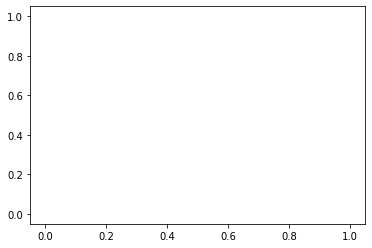

Current percentage of epoch: 0.01
Train (epoch 1/15) [0/800 (0%)]	Loss: 0.344465	Accuracy: 94.65179443359375
learning rate 1e-05
shape of output: torch.Size([1, 2, 256, 256]) <class 'torch.Tensor'>
output: tensor([[[[ 1.9148,  2.4331,  2.9264,  3.1704,  3.3780],
          [ 2.4175,  2.6807,  3.2546,  3.6095,  3.9462],
          [ 2.8932,  3.2225,  3.9347,  4.4044,  4.8373],
          [ 3.0905,  3.4851,  4.2581,  4.7770,  5.1690]],

         [[-1.9148, -2.4329, -2.9263, -3.1702, -3.3778],
          [-2.4174, -2.6804, -3.2543, -3.6091, -3.9459],
          [-2.8931, -3.2222, -3.9343, -4.4040, -4.8369],
          [-3.0903, -3.4848, -4.2577, -4.7766, -5.1685]]]], device='cuda:0',
       grad_fn=<SliceBackward>)
pred: [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
shape of output: torch.Size([1, 2, 256, 256]) <class 'torch.Tensor'>
output: tensor([[[[ 1.2629,  1.5547,  1.7596,  1.8354,  1.8074],
          [ 1.5707,  1.7553,  1.8862,  1.9957,  2.0033],
          [ 1.7918,  1.9417,  2.06

       grad_fn=<SliceBackward>)
pred: [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
shape of output: torch.Size([1, 2, 256, 256]) <class 'torch.Tensor'>
output: tensor([[[[ 0.6561,  0.7919,  0.8727,  0.8657,  0.9062],
          [ 0.6988,  0.8150,  0.8916,  0.8829,  0.9353],
          [ 0.7175,  0.8503,  0.9383,  0.9247,  0.9771],
          [ 0.6167,  0.7314,  0.8454,  0.8410,  0.9129]],

         [[-0.6562, -0.7919, -0.8727, -0.8657, -0.9062],
          [-0.6988, -0.8149, -0.8914, -0.8828, -0.9351],
          [-0.7175, -0.8502, -0.9381, -0.9246, -0.9770],
          [-0.6167, -0.7313, -0.8452, -0.8409, -0.9127]]]], device='cuda:0',
       grad_fn=<SliceBackward>)
pred: [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
shape of output: torch.Size([1, 2, 256, 256]) <class 'torch.Tensor'>
output: tensor([[[[ 1.3092,  1.6378,  1.8816,  2.0131,  2.0317],
          [ 1.5888,  1.7455,  1.8808,  2.0236,  2.0946],
          [ 1.7318,  1.8010,  1.8853,  1.9830,  2.0382],
          [ 1.8

       grad_fn=<SliceBackward>)
pred: [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
shape of output: torch.Size([1, 2, 256, 256]) <class 'torch.Tensor'>
output: tensor([[[[ 1.4924,  1.8788,  2.2272,  2.3470,  2.4149],
          [ 1.9367,  2.1988,  2.4693,  2.6179,  2.7380],
          [ 2.1998,  2.3975,  2.6661,  2.8660,  3.0368],
          [ 2.3269,  2.5913,  2.8604,  3.0927,  3.2870]],

         [[-1.4924, -1.8787, -2.2271, -2.3469, -2.4148],
          [-1.9367, -2.1986, -2.4691, -2.6177, -2.7378],
          [-2.1997, -2.3973, -2.6659, -2.8657, -3.0365],
          [-2.3268, -2.5911, -2.8602, -3.0925, -3.2867]]]], device='cuda:0',
       grad_fn=<SliceBackward>)
pred: [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
shape of output: torch.Size([1, 2, 256, 256]) <class 'torch.Tensor'>
output: tensor([[[[ 1.0233,  1.1912,  1.2941,  1.3052,  1.3261],
          [ 1.2374,  1.3314,  1.4061,  1.4498,  1.5163],
          [ 1.3546,  1.4093,  1.5060,  1.6090,  1.7337],
          [ 1.3

       grad_fn=<SliceBackward>)
pred: [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
shape of output: torch.Size([1, 2, 256, 256]) <class 'torch.Tensor'>
output: tensor([[[[-0.0809, -0.1261, -0.2241, -0.2557, -0.2405],
          [-0.1233, -0.0412, -0.1095, -0.0985, -0.0561],
          [-0.2528, -0.1726, -0.2132, -0.1525, -0.0605],
          [-0.2394, -0.1193, -0.1117, -0.0261,  0.0851]],

         [[ 0.0808,  0.1260,  0.2241,  0.2557,  0.2405],
          [ 0.1233,  0.0412,  0.1096,  0.0985,  0.0561],
          [ 0.2528,  0.1727,  0.2133,  0.1526,  0.0606],
          [ 0.2394,  0.1194,  0.1118,  0.0262, -0.0850]]]], device='cuda:0',
       grad_fn=<SliceBackward>)
pred: [[1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 0]]
shape of output: torch.Size([1, 2, 256, 256]) <class 'torch.Tensor'>
output: tensor([[[[ 1.1015,  1.3323,  1.4356,  1.3434,  1.2674],
          [ 1.3734,  1.4883,  1.4845,  1.3862,  1.3532],
          [ 1.5583,  1.5627,  1.4647,  1.3870,  1.4208],
          [ 1.7

       grad_fn=<SliceBackward>)
pred: [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
shape of output: torch.Size([1, 2, 256, 256]) <class 'torch.Tensor'>
output: tensor([[[[ 1.5305,  1.9285,  2.2693,  2.4200,  2.5094],
          [ 1.9269,  2.1981,  2.4867,  2.7328,  2.9433],
          [ 2.1969,  2.4158,  2.7102,  2.9868,  3.2114],
          [ 2.3544,  2.6531,  3.0066,  3.3130,  3.5565]],

         [[-1.5305, -1.9285, -2.2692, -2.4199, -2.5093],
          [-1.9268, -2.1980, -2.4865, -2.7326, -2.9431],
          [-2.1968, -2.4157, -2.7100, -2.9866, -3.2111],
          [-2.3543, -2.6529, -3.0064, -3.3127, -3.5562]]]], device='cuda:0',
       grad_fn=<SliceBackward>)
pred: [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
shape of output: torch.Size([1, 2, 256, 256]) <class 'torch.Tensor'>
output: tensor([[[[-0.5345, -0.7165, -0.7962, -0.6483, -0.3935],
          [-0.7647, -0.8540, -0.9284, -0.7262, -0.4365],
          [-0.9419, -1.0126, -1.0347, -0.7670, -0.4330],
          [-0.9

       grad_fn=<SliceBackward>)
pred: [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
shape of output: torch.Size([1, 2, 256, 256]) <class 'torch.Tensor'>
output: tensor([[[[ 0.9020,  1.0894,  1.2116,  1.2040,  1.1566],
          [ 1.1501,  1.2819,  1.3547,  1.3564,  1.3379],
          [ 1.3396,  1.4354,  1.4946,  1.4908,  1.4814],
          [ 1.5139,  1.6557,  1.7300,  1.6997,  1.6437]],

         [[-0.9021, -1.0894, -1.2116, -1.2040, -1.1567],
          [-1.1501, -1.2819, -1.3546, -1.3563, -1.3378],
          [-1.3396, -1.4353, -1.4945, -1.4907, -1.4813],
          [-1.5140, -1.6556, -1.7299, -1.6996, -1.6436]]]], device='cuda:0',
       grad_fn=<SliceBackward>)
pred: [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
shape of output: torch.Size([1, 2, 256, 256]) <class 'torch.Tensor'>
output: tensor([[[[ 1.7539,  2.2077,  2.6455,  2.8360,  2.9916],
          [ 2.1994,  2.4911,  2.9683,  3.2606,  3.5372],
          [ 2.6074,  2.9622,  3.5557,  3.9362,  4.2736],
          [ 2.7

       grad_fn=<SliceBackward>)
pred: [[0 0 0 0 1]
 [0 0 1 1 1]
 [0 1 1 1 1]
 [1 1 1 1 1]]
shape of output: torch.Size([1, 2, 256, 256]) <class 'torch.Tensor'>
output: tensor([[[[ 1.2338,  1.5023,  1.7099,  1.8086,  1.8822],
          [ 1.5454,  1.7201,  1.8705,  2.0146,  2.1653],
          [ 1.7468,  1.8812,  2.0210,  2.2230,  2.4465],
          [ 1.8393,  1.9826,  2.1266,  2.3395,  2.5757]],

         [[-1.2338, -1.5023, -1.7098, -1.8085, -1.8822],
          [-1.5454, -1.7200, -1.8704, -2.0144, -2.1651],
          [-1.7467, -1.8810, -2.0208, -2.2228, -2.4463],
          [-1.8393, -1.9825, -2.1265, -2.3393, -2.5755]]]], device='cuda:0',
       grad_fn=<SliceBackward>)
pred: [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
shape of output: torch.Size([1, 2, 256, 256]) <class 'torch.Tensor'>
output: tensor([[[[ 1.0433,  1.2659,  1.4369,  1.4577,  1.3699],
          [ 1.2940,  1.3955,  1.5014,  1.5461,  1.4927],
          [ 1.4403,  1.4876,  1.5992,  1.6827,  1.6444],
          [ 1.5

       grad_fn=<SliceBackward>)
pred: [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
shape of output: torch.Size([1, 2, 256, 256]) <class 'torch.Tensor'>
output: tensor([[[[ 1.9357,  2.4757,  2.9945,  3.2603,  3.4972],
          [ 2.4214,  2.7236,  3.3764,  3.7805,  4.1601],
          [ 2.9244,  3.3299,  4.1649,  4.7211,  5.1536],
          [ 3.1434,  3.6513,  4.5912,  5.1567,  5.5731]],

         [[-1.9357, -2.4756, -2.9943, -3.2601, -3.4970],
          [-2.4213, -2.7234, -3.3760, -3.7801, -4.1597],
          [-2.9243, -3.3296, -4.1645, -4.7207, -5.1531],
          [-3.1432, -3.6509, -4.5908, -5.1562, -5.5726]]]], device='cuda:0',
       grad_fn=<SliceBackward>)
pred: [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
shape of output: torch.Size([1, 2, 256, 256]) <class 'torch.Tensor'>
output: tensor([[[[ 0.2260,  0.1557,  0.1311, -0.2022, -0.5980],
          [ 0.1079, -0.0253,  0.0033, -0.3627, -0.7747],
          [-0.0131, -0.2518, -0.1838, -0.5843, -1.0221],
          [ 0.0

       grad_fn=<SliceBackward>)
pred: [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
shape of output: torch.Size([1, 2, 256, 256]) <class 'torch.Tensor'>
output: tensor([[[[ 0.3085,  0.2617,  0.1827,  0.1503,  0.1592],
          [ 0.3641,  0.3417,  0.2626,  0.2359,  0.2362],
          [ 0.4326,  0.4630,  0.4605,  0.4535,  0.4753],
          [ 0.4567,  0.5015,  0.5408,  0.5380,  0.5467]],

         [[-0.3086, -0.2617, -0.1827, -0.1503, -0.1592],
          [-0.3641, -0.3416, -0.2625, -0.2359, -0.2361],
          [-0.4327, -0.4629, -0.4604, -0.4534, -0.4752],
          [-0.4568, -0.5014, -0.5407, -0.5379, -0.5466]]]], device='cuda:0',
       grad_fn=<SliceBackward>)
pred: [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
shape of output: torch.Size([1, 2, 256, 256]) <class 'torch.Tensor'>
output: tensor([[[[ 0.6903,  0.8498,  0.9661,  0.9450,  0.9445],
          [ 0.7708,  0.8861,  0.9556,  0.9013,  0.9047],
          [ 0.8123,  0.9063,  0.9768,  0.9370,  0.9596],
          [ 0.7

       grad_fn=<SliceBackward>)
pred: [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
shape of output: torch.Size([1, 2, 256, 256]) <class 'torch.Tensor'>
output: tensor([[[[ 0.1911,  0.1990,  0.1860,  0.1377,  0.1316],
          [ 0.1430,  0.1790,  0.1504,  0.0925,  0.0961],
          [ 0.0581,  0.1022,  0.1130,  0.0737,  0.0896],
          [ 0.0740,  0.1818,  0.2655,  0.2188,  0.2221]],

         [[-0.1912, -0.1990, -0.1860, -0.1376, -0.1316],
          [-0.1430, -0.1789, -0.1502, -0.0924, -0.0960],
          [-0.0581, -0.1021, -0.1128, -0.0736, -0.0894],
          [-0.0740, -0.1817, -0.2654, -0.2187, -0.2220]]]], device='cuda:0',
       grad_fn=<SliceBackward>)
pred: [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
shape of output: torch.Size([1, 2, 256, 256]) <class 'torch.Tensor'>
output: tensor([[[[ 0.6966,  0.8667,  0.9631,  1.0262,  1.1127],
          [ 0.8407,  1.0113,  1.1008,  1.1827,  1.2999],
          [ 0.9072,  1.0486,  1.1546,  1.2608,  1.4152],
          [ 0.9

       grad_fn=<SliceBackward>)
pred: [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
shape of output: torch.Size([1, 2, 256, 256]) <class 'torch.Tensor'>
output: tensor([[[[ 1.2530,  1.5875,  1.8714,  2.0394,  2.1794],
          [ 1.5607,  1.8040,  2.0401,  2.2403,  2.4433],
          [ 1.7354,  1.9047,  2.1234,  2.3493,  2.5923],
          [ 1.9066,  2.1223,  2.3826,  2.6095,  2.8441]],

         [[-1.2531, -1.5875, -1.8714, -2.0394, -2.1793],
          [-1.5607, -1.8038, -2.0400, -2.2402, -2.4432],
          [-1.7353, -1.9046, -2.1232, -2.3491, -2.5921],
          [-1.9066, -2.1222, -2.3824, -2.6093, -2.8439]]]], device='cuda:0',
       grad_fn=<SliceBackward>)
pred: [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
shape of output: torch.Size([1, 2, 256, 256]) <class 'torch.Tensor'>
output: tensor([[[[ 1.1256,  1.4123,  1.6205,  1.8098,  1.9643],
          [ 1.3904,  1.5829,  1.7179,  1.9600,  2.1701],
          [ 1.5473,  1.6705,  1.7896,  2.0704,  2.3261],
          [ 1.7

       grad_fn=<SliceBackward>)
pred: [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
shape of output: torch.Size([1, 2, 256, 256]) <class 'torch.Tensor'>
output: tensor([[[[-0.0389, -0.0518, -0.1475, -0.1600, -0.1388],
          [-0.0084,  0.1166,  0.0278,  0.0381,  0.0689],
          [-0.0791,  0.0239, -0.0656, -0.0490, -0.0068],
          [-0.0250,  0.0823,  0.0287,  0.0533,  0.0986]],

         [[ 0.0388,  0.0517,  0.1475,  0.1600,  0.1388],
          [ 0.0084, -0.1166, -0.0278, -0.0381, -0.0688],
          [ 0.0791, -0.0239,  0.0657,  0.0490,  0.0068],
          [ 0.0249, -0.0823, -0.0287, -0.0533, -0.0986]]]], device='cuda:0',
       grad_fn=<SliceBackward>)
pred: [[1 1 1 1 1]
 [1 0 0 0 0]
 [1 0 1 1 1]
 [1 0 0 0 0]]
shape of output: torch.Size([1, 2, 256, 256]) <class 'torch.Tensor'>
output: tensor([[[[-0.6323, -0.8850, -1.0740, -1.2327, -1.3364],
          [-0.8532, -0.9925, -1.2019, -1.4283, -1.5926],
          [-1.0502, -1.1878, -1.3597, -1.5239, -1.6437],
          [-1.1

       grad_fn=<SliceBackward>)
pred: [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
shape of output: torch.Size([1, 2, 256, 256]) <class 'torch.Tensor'>
output: tensor([[[[ 1.1363,  1.4223,  1.6644,  1.7563,  1.8698],
          [ 1.4400,  1.6947,  1.9366,  2.0207,  2.1490],
          [ 1.7171,  1.9914,  2.2697,  2.3680,  2.4984],
          [ 1.8510,  2.1133,  2.3955,  2.4366,  2.5218]],

         [[-1.1364, -1.4223, -1.6644, -1.7563, -1.8698],
          [-1.4399, -1.6946, -1.9364, -2.0206, -2.1488],
          [-1.7170, -1.9913, -2.2696, -2.3678, -2.4983],
          [-1.8509, -2.1131, -2.3953, -2.4364, -2.5216]]]], device='cuda:0',
       grad_fn=<SliceBackward>)
pred: [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
shape of output: torch.Size([1, 2, 256, 256]) <class 'torch.Tensor'>
output: tensor([[[[ 0.8982,  0.9879,  1.0838,  1.2110,  1.2896],
          [ 1.2262,  1.2257,  1.1963,  1.3818,  1.5101],
          [ 1.5181,  1.5179,  1.3938,  1.6168,  1.7367],
          [ 1.6

       grad_fn=<SliceBackward>)
pred: [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
shape of output: torch.Size([1, 2, 256, 256]) <class 'torch.Tensor'>
output: tensor([[[[ 1.8922,  2.4198,  2.8930,  3.1215,  3.3090],
          [ 2.3947,  2.6922,  3.2571,  3.6049,  3.9237],
          [ 2.8346,  3.2416,  3.9459,  4.4059,  4.7691],
          [ 3.0194,  3.5252,  4.2900,  4.7490,  5.0901]],

         [[-1.8922, -2.4197, -2.8928, -3.1213, -3.3088],
          [-2.3946, -2.6920, -3.2568, -3.6046, -3.9233],
          [-2.8345, -3.2413, -3.9456, -4.4055, -4.7686],
          [-3.0192, -3.5249, -4.2896, -4.7486, -5.0896]]]], device='cuda:0',
       grad_fn=<SliceBackward>)
pred: [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
shape of output: torch.Size([1, 2, 256, 256]) <class 'torch.Tensor'>
output: tensor([[[[ 1.6455,  2.1051,  2.5249,  2.6940,  2.8258],
          [ 2.0922,  2.4406,  2.8704,  3.1204,  3.3320],
          [ 2.4447,  2.8080,  3.3164,  3.6129,  3.8704],
          [ 2.5

       grad_fn=<SliceBackward>)
pred: [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
shape of output: torch.Size([1, 2, 256, 256]) <class 'torch.Tensor'>
output: tensor([[[[ 0.0279, -0.0671, -0.2125, -0.3720, -0.5074],
          [ 0.0031, -0.0182, -0.1680, -0.3410, -0.4880],
          [-0.0982, -0.0978, -0.2215, -0.3979, -0.5483],
          [-0.2184, -0.2218, -0.3192, -0.4976, -0.6265]],

         [[-0.0280,  0.0671,  0.2124,  0.3720,  0.5074],
          [-0.0032,  0.0182,  0.1681,  0.3410,  0.4880],
          [ 0.0982,  0.0979,  0.2216,  0.3979,  0.5484],
          [ 0.2184,  0.2218,  0.3192,  0.4977,  0.6265]]]], device='cuda:0',
       grad_fn=<SliceBackward>)
pred: [[0 1 1 1 1]
 [0 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]
shape of output: torch.Size([1, 2, 256, 256]) <class 'torch.Tensor'>
output: tensor([[[[ 1.1825,  1.4694,  1.7045,  1.8470,  1.9056],
          [ 1.4904,  1.6986,  1.9135,  2.1272,  2.2348],
          [ 1.7120,  1.9124,  2.1696,  2.4160,  2.5441],
          [ 1.8

       grad_fn=<SliceBackward>)
pred: [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
shape of output: torch.Size([1, 2, 256, 256]) <class 'torch.Tensor'>
output: tensor([[[[ 0.5274,  0.6033,  0.6235,  0.7096,  0.7992],
          [ 0.6615,  0.7207,  0.7000,  0.8731,  1.0767],
          [ 0.7497,  0.7880,  0.7972,  1.0713,  1.3730],
          [ 0.8296,  0.8252,  0.8030,  1.0729,  1.3666]],

         [[-0.5275, -0.6033, -0.6235, -0.7096, -0.7992],
          [-0.6614, -0.7206, -0.6999, -0.8730, -1.0766],
          [-0.7497, -0.7879, -0.7970, -1.0711, -1.3729],
          [-0.8295, -0.8251, -0.8029, -1.0727, -1.3664]]]], device='cuda:0',
       grad_fn=<SliceBackward>)
pred: [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
shape of output: torch.Size([1, 2, 256, 256]) <class 'torch.Tensor'>
output: tensor([[[[ 0.7799,  0.9749,  1.0573,  1.1740,  1.2765],
          [ 0.9401,  1.1241,  1.1762,  1.3471,  1.5105],
          [ 0.9868,  1.1193,  1.1517,  1.3436,  1.5529],
          [ 1.2

       grad_fn=<SliceBackward>)
pred: [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
shape of output: torch.Size([1, 2, 256, 256]) <class 'torch.Tensor'>
output: tensor([[[[ 1.2652,  1.6189,  1.9088,  2.0042,  2.0848],
          [ 1.5200,  1.7562,  1.9695,  2.0355,  2.1207],
          [ 1.7001,  1.8556,  2.0030,  2.0693,  2.1817],
          [ 1.8292,  1.9961,  2.1231,  2.2171,  2.3726]],

         [[-1.2653, -1.6189, -1.9088, -2.0042, -2.0847],
          [-1.5200, -1.7561, -1.9693, -2.0353, -2.1205],
          [-1.7000, -1.8554, -2.0028, -2.0691, -2.1815],
          [-1.8292, -1.9959, -2.1229, -2.2169, -2.3724]]]], device='cuda:0',
       grad_fn=<SliceBackward>)
pred: [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
shape of output: torch.Size([1, 2, 256, 256]) <class 'torch.Tensor'>
output: tensor([[[[ 0.4820,  0.6032,  0.7255,  0.7411,  0.8012],
          [ 0.5377,  0.6883,  0.8156,  0.8156,  0.8767],
          [ 0.5829,  0.7550,  0.8936,  0.8845,  0.9335],
          [ 0.6

       grad_fn=<SliceBackward>)
pred: [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
shape of output: torch.Size([1, 2, 256, 256]) <class 'torch.Tensor'>
output: tensor([[[[ 0.8490,  0.9157,  0.9476,  0.8769,  0.6969],
          [ 0.9859,  0.9010,  0.8408,  0.8412,  0.7442],
          [ 1.0277,  0.8767,  0.8248,  0.8721,  0.8178],
          [ 1.1077,  1.0018,  0.9432,  0.9607,  0.8876]],

         [[-0.8491, -0.9158, -0.9476, -0.8770, -0.6969],
          [-0.9860, -0.9009, -0.8407, -0.8412, -0.7442],
          [-1.0277, -0.8767, -0.8247, -0.8720, -0.8177],
          [-1.1078, -1.0018, -0.9431, -0.9606, -0.8875]]]], device='cuda:0',
       grad_fn=<SliceBackward>)
pred: [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
shape of output: torch.Size([1, 2, 256, 256]) <class 'torch.Tensor'>
output: tensor([[[[ 1.2891,  1.5886,  1.8316,  1.9845,  2.0425],
          [ 1.6317,  1.8310,  1.9973,  2.1921,  2.3107],
          [ 1.8550,  2.0383,  2.2154,  2.4233,  2.5763],
          [ 1.9

       grad_fn=<SliceBackward>)
pred: [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
shape of output: torch.Size([1, 2, 256, 256]) <class 'torch.Tensor'>
output: tensor([[[[-0.1915, -0.3605, -0.5335, -0.7907, -1.0214],
          [-0.3255, -0.4379, -0.5738, -0.8349, -1.0800],
          [-0.4234, -0.5422, -0.6541, -0.9162, -1.1631],
          [-0.4698, -0.6445, -0.7873, -1.0826, -1.3306]],

         [[ 0.1914,  0.3605,  0.5335,  0.7907,  1.0214],
          [ 0.3254,  0.4379,  0.5739,  0.8350,  1.0801],
          [ 0.4234,  0.5423,  0.6543,  0.9163,  1.1633],
          [ 0.4697,  0.6445,  0.7874,  1.0827,  1.3307]]]], device='cuda:0',
       grad_fn=<SliceBackward>)
pred: [[1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]
shape of output: torch.Size([1, 2, 256, 256]) <class 'torch.Tensor'>
output: tensor([[[[ 2.0621,  2.7085,  3.2219,  3.4982,  3.7218],
          [ 2.6504,  2.9971,  3.6529,  4.0493,  4.4039],
          [ 3.1150,  3.6365,  4.4721,  4.9828,  5.3719],
          [ 3.3

       grad_fn=<SliceBackward>)
pred: [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
shape of output: torch.Size([1, 2, 256, 256]) <class 'torch.Tensor'>
output: tensor([[[[ 0.2164,  0.1878,  0.2205,  0.1571,  0.1462],
          [ 0.1514,  0.1373,  0.2268,  0.2115,  0.2447],
          [ 0.1042,  0.0923,  0.2251,  0.2626,  0.3429],
          [ 0.2143,  0.2433,  0.3723,  0.3663,  0.4026]],

         [[-0.2165, -0.1878, -0.2205, -0.1572, -0.1462],
          [-0.1515, -0.1372, -0.2267, -0.2115, -0.2447],
          [-0.1042, -0.0921, -0.2249, -0.2625, -0.3428],
          [-0.2144, -0.2432, -0.3722, -0.3662, -0.4025]]]], device='cuda:0',
       grad_fn=<SliceBackward>)
pred: [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
shape of output: torch.Size([1, 2, 256, 256]) <class 'torch.Tensor'>
output: tensor([[[[ 0.5497,  0.6348,  0.6585,  0.6499,  0.6306],
          [ 0.6495,  0.7253,  0.7219,  0.7074,  0.6768],
          [ 0.6741,  0.7178,  0.7304,  0.7294,  0.7056],
          [ 0.7

       grad_fn=<SliceBackward>)
pred: [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
shape of output: torch.Size([1, 2, 256, 256]) <class 'torch.Tensor'>
output: tensor([[[[ 1.7517,  2.2241,  2.6723,  2.8741,  3.0551],
          [ 2.1921,  2.5270,  3.0255,  3.3011,  3.5721],
          [ 2.5670,  2.9817,  3.5910,  3.9446,  4.2898],
          [ 2.6932,  3.1977,  3.8620,  4.2345,  4.5401]],

         [[-1.7517, -2.2240, -2.6722, -2.8739, -3.0549],
          [-2.1920, -2.5268, -3.0252, -3.3008, -3.5718],
          [-2.5669, -2.9814, -3.5906, -3.9442, -4.2894],
          [-2.6931, -3.1975, -3.8617, -4.2341, -4.5397]]]], device='cuda:0',
       grad_fn=<SliceBackward>)
pred: [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
shape of output: torch.Size([1, 2, 256, 256]) <class 'torch.Tensor'>
output: tensor([[[[ 0.6436,  0.6963,  0.7419,  0.7618,  0.8070],
          [ 0.7004,  0.6919,  0.7126,  0.7584,  0.8499],
          [ 0.7839,  0.8332,  0.8762,  0.9049,  0.9625],
          [ 0.9

       grad_fn=<SliceBackward>)
pred: [[1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]
shape of output: torch.Size([1, 2, 256, 256]) <class 'torch.Tensor'>
output: tensor([[[[-0.3661, -0.5393, -0.6870, -0.7249, -0.7492],
          [-0.3675, -0.3834, -0.5139, -0.5147, -0.5134],
          [-0.3269, -0.2411, -0.2867, -0.2137, -0.1754],
          [-0.3071, -0.3029, -0.3900, -0.3291, -0.3160]],

         [[ 0.3661,  0.5393,  0.6869,  0.7249,  0.7492],
          [ 0.3675,  0.3835,  0.5140,  0.5149,  0.5135],
          [ 0.3269,  0.2412,  0.2868,  0.2138,  0.1756],
          [ 0.3071,  0.3030,  0.3901,  0.3293,  0.3161]]]], device='cuda:0',
       grad_fn=<SliceBackward>)
pred: [[1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]
shape of output: torch.Size([1, 2, 256, 256]) <class 'torch.Tensor'>
output: tensor([[[[ 1.0086,  1.2714,  1.4817,  1.6038,  1.7315],
          [ 1.2756,  1.5271,  1.6972,  1.8086,  1.9266],
          [ 1.5114,  1.8154,  1.9936,  2.0964,  2.1817],
          [ 1.5

       grad_fn=<SliceBackward>)
pred: [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
shape of output: torch.Size([1, 2, 256, 256]) <class 'torch.Tensor'>
output: tensor([[[[-0.1935, -0.4294, -0.5698, -0.5851, -0.4909],
          [-0.3908, -0.6222, -0.7808, -0.7247, -0.5824],
          [-0.5816, -0.7803, -0.8961, -0.7506, -0.5669],
          [-0.9349, -1.2212, -1.3362, -1.0977, -0.7901]],

         [[ 0.1934,  0.4294,  0.5697,  0.5851,  0.4908],
          [ 0.3907,  0.6223,  0.7809,  0.7247,  0.5824],
          [ 0.5816,  0.7804,  0.8962,  0.7507,  0.5669],
          [ 0.9349,  1.2213,  1.3363,  1.0977,  0.7901]]]], device='cuda:0',
       grad_fn=<SliceBackward>)
pred: [[1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]
shape of output: torch.Size([1, 2, 256, 256]) <class 'torch.Tensor'>
output: tensor([[[[ 0.9395,  1.1363,  1.2108,  1.2465,  1.2459],
          [ 1.1730,  1.3012,  1.3015,  1.3509,  1.3798],
          [ 1.3370,  1.3977,  1.3548,  1.4024,  1.4306],
          [ 1.5

       grad_fn=<SliceBackward>)
pred: [[1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]
shape of output: torch.Size([1, 2, 256, 256]) <class 'torch.Tensor'>
output: tensor([[[[ 0.5119,  0.5624,  0.4465,  0.2992,  0.1869],
          [ 0.4689,  0.4693,  0.3122,  0.2161,  0.1681],
          [ 0.3095,  0.2119,  0.0708,  0.0631,  0.1516],
          [ 0.3109,  0.2374,  0.1583,  0.1875,  0.3492]],

         [[-0.5120, -0.5624, -0.4465, -0.2992, -0.1870],
          [-0.4690, -0.4693, -0.3121, -0.2161, -0.1681],
          [-0.3095, -0.2119, -0.0707, -0.0630, -0.1516],
          [-0.3109, -0.2374, -0.1582, -0.1875, -0.3492]]]], device='cuda:0',
       grad_fn=<SliceBackward>)
pred: [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
shape of output: torch.Size([1, 2, 256, 256]) <class 'torch.Tensor'>
output: tensor([[[[ 0.1958,  0.2287,  0.1928,  0.1510,  0.1294],
          [ 0.2305,  0.3403,  0.2893,  0.2451,  0.2359],
          [ 0.1586,  0.2369,  0.1843,  0.1765,  0.2119],
          [ 0.1

       grad_fn=<SliceBackward>)
pred: [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
shape of output: torch.Size([1, 2, 256, 256]) <class 'torch.Tensor'>
output: tensor([[[[ 1.1836,  1.4350,  1.6503,  1.8132,  1.9903],
          [ 1.4975,  1.6503,  1.8228,  2.0610,  2.3384],
          [ 1.7416,  1.8790,  2.0945,  2.3926,  2.7320],
          [ 1.8649,  2.0243,  2.2661,  2.5296,  2.8503]],

         [[-1.1837, -1.4350, -1.6502, -1.8132, -1.9903],
          [-1.4974, -1.6501, -1.8226, -2.0608, -2.3383],
          [-1.7416, -1.8789, -2.0943, -2.3923, -2.7318],
          [-1.8648, -2.0241, -2.2659, -2.5294, -2.8501]]]], device='cuda:0',
       grad_fn=<SliceBackward>)
pred: [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
shape of output: torch.Size([1, 2, 256, 256]) <class 'torch.Tensor'>
output: tensor([[[[ 0.8491,  0.9689,  0.9972,  0.9312,  0.8408],
          [ 0.9761,  1.0010,  0.9801,  0.9813,  0.9445],
          [ 1.0561,  1.0319,  1.0090,  1.0344,  1.0447],
          [ 1.2

       grad_fn=<SliceBackward>)
pred: [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
shape of output: torch.Size([1, 2, 256, 256]) <class 'torch.Tensor'>
output: tensor([[[[ 1.0859,  1.3417,  1.5731,  1.6292,  1.6402],
          [ 1.3888,  1.5847,  1.8222,  1.8789,  1.9108],
          [ 1.6075,  1.7884,  2.0649,  2.1523,  2.2099],
          [ 1.7598,  1.9901,  2.2983,  2.3508,  2.3744]],

         [[-1.0859, -1.3418, -1.5731, -1.6292, -1.6402],
          [-1.3888, -1.5846, -1.8221, -1.8789, -1.9107],
          [-1.6075, -1.7883, -2.0648, -2.1522, -2.2098],
          [-1.7598, -1.9900, -2.2981, -2.3507, -2.3743]]]], device='cuda:0',
       grad_fn=<SliceBackward>)
pred: [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
shape of output: torch.Size([1, 2, 256, 256]) <class 'torch.Tensor'>
output: tensor([[[[ 1.0668,  1.2698,  1.4507,  1.5475,  1.5949],
          [ 1.3766,  1.4886,  1.5741,  1.6681,  1.7452],
          [ 1.6285,  1.7157,  1.7033,  1.7629,  1.8030],
          [ 1.8

       grad_fn=<SliceBackward>)
pred: [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
shape of output: torch.Size([1, 2, 256, 256]) <class 'torch.Tensor'>
output: tensor([[[[ 0.3202,  0.3981,  0.3679,  0.3445,  0.3331],
          [ 0.3099,  0.4275,  0.3911,  0.4056,  0.4391],
          [ 0.1912,  0.2771,  0.2961,  0.3790,  0.4888],
          [ 0.3013,  0.4806,  0.5885,  0.6655,  0.7435]],

         [[-0.3203, -0.3981, -0.3679, -0.3446, -0.3331],
          [-0.3099, -0.4275, -0.3911, -0.4055, -0.4391],
          [-0.1912, -0.2770, -0.2960, -0.3790, -0.4887],
          [-0.3013, -0.4806, -0.5884, -0.6654, -0.7434]]]], device='cuda:0',
       grad_fn=<SliceBackward>)
pred: [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
shape of output: torch.Size([1, 2, 256, 256]) <class 'torch.Tensor'>
output: tensor([[[[ 1.3184,  1.6755,  1.9631,  2.0595,  2.1728],
          [ 1.6463,  1.9586,  2.2283,  2.3198,  2.4592],
          [ 1.8858,  2.2284,  2.5316,  2.6359,  2.7897],
          [ 1.9

       grad_fn=<SliceBackward>)
pred: [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
shape of output: torch.Size([1, 2, 256, 256]) <class 'torch.Tensor'>
output: tensor([[[[ 0.8319,  1.0179,  1.1061,  1.1298,  1.1981],
          [ 0.9996,  1.1591,  1.2068,  1.2360,  1.3375],
          [ 1.1451,  1.3022,  1.3303,  1.3706,  1.4958],
          [ 1.2564,  1.4039,  1.4327,  1.4737,  1.5896]],

         [[-0.8320, -1.0179, -1.1061, -1.1297, -1.1980],
          [-0.9996, -1.1591, -1.2067, -1.2359, -1.3374],
          [-1.1451, -1.3021, -1.3302, -1.3705, -1.4957],
          [-1.2564, -1.4038, -1.4326, -1.4736, -1.5895]]]], device='cuda:0',
       grad_fn=<SliceBackward>)
pred: [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
shape of output: torch.Size([1, 2, 256, 256]) <class 'torch.Tensor'>
output: tensor([[[[ 0.9680,  1.1856,  1.3822,  1.5326,  1.6666],
          [ 1.1966,  1.3737,  1.5572,  1.7445,  1.9323],
          [ 1.3185,  1.4867,  1.6989,  1.9241,  2.1734],
          [ 1.4

       grad_fn=<SliceBackward>)
pred: [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
shape of output: torch.Size([1, 2, 256, 256]) <class 'torch.Tensor'>
output: tensor([[[[ 0.6601,  0.7816,  0.8546,  0.8627,  0.8910],
          [ 0.8017,  0.9241,  0.9765,  0.9990,  1.0372],
          [ 0.8487,  0.9723,  1.0556,  1.0840,  1.1258],
          [ 0.8937,  1.0376,  1.1491,  1.2048,  1.2926]],

         [[-0.6602, -0.7816, -0.8546, -0.8627, -0.8910],
          [-0.8017, -0.9240, -0.9764, -0.9989, -1.0371],
          [-0.8487, -0.9722, -1.0555, -1.0839, -1.1257],
          [-0.8937, -1.0375, -1.1490, -1.2047, -1.2926]]]], device='cuda:0',
       grad_fn=<SliceBackward>)
pred: [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
shape of output: torch.Size([1, 2, 256, 256]) <class 'torch.Tensor'>
output: tensor([[[[ 1.8702,  2.3791,  2.8488,  3.0720,  3.2563],
          [ 2.3563,  2.6421,  3.1790,  3.5122,  3.8233],
          [ 2.7880,  3.1700,  3.8357,  4.2723,  4.6443],
          [ 2.9

       grad_fn=<SliceBackward>)
pred: [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
shape of output: torch.Size([1, 2, 256, 256]) <class 'torch.Tensor'>
output: tensor([[[[ 0.5471,  0.6539,  0.7080,  0.7138,  0.7591],
          [ 0.6386,  0.7499,  0.8041,  0.8190,  0.8808],
          [ 0.6924,  0.7685,  0.8153,  0.8177,  0.8672],
          [ 0.8581,  0.9453,  0.9834,  0.9650,  1.0400]],

         [[-0.5472, -0.6539, -0.7079, -0.7137, -0.7591],
          [-0.6386, -0.7498, -0.8039, -0.8189, -0.8806],
          [-0.6924, -0.7683, -0.8151, -0.8175, -0.8670],
          [-0.8581, -0.9452, -0.9832, -0.9649, -1.0398]]]], device='cuda:0',
       grad_fn=<SliceBackward>)
pred: [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
shape of output: torch.Size([1, 2, 256, 256]) <class 'torch.Tensor'>
output: tensor([[[[ 0.2519,  0.3737,  0.5576,  0.7655,  0.9856],
          [ 0.2325,  0.4123,  0.6035,  0.7955,  0.9699],
          [ 0.2106,  0.4420,  0.7056,  0.9108,  1.0311],
          [ 0.1

       grad_fn=<SliceBackward>)
pred: [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
shape of output: torch.Size([1, 2, 256, 256]) <class 'torch.Tensor'>
output: tensor([[[[ 1.1412,  1.3717,  1.6230,  1.8244,  1.9118],
          [ 1.4364,  1.5563,  1.7511,  2.0078,  2.1437],
          [ 1.5738,  1.6826,  1.8943,  2.2021,  2.3596],
          [ 1.5674,  1.7239,  1.9374,  2.2067,  2.3286]],

         [[-1.1412, -1.3717, -1.6230, -1.8244, -1.9118],
          [-1.4365, -1.5563, -1.7510, -2.0076, -2.1436],
          [-1.5738, -1.6825, -1.8942, -2.2020, -2.3595],
          [-1.5674, -1.7239, -1.9373, -2.2066, -2.3285]]]], device='cuda:0',
       grad_fn=<SliceBackward>)
pred: [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
shape of output: torch.Size([1, 2, 256, 256]) <class 'torch.Tensor'>
output: tensor([[[[ 0.8568,  1.0562,  1.1493,  1.1768,  1.1819],
          [ 0.9277,  1.0253,  1.0283,  1.0756,  1.1230],
          [ 0.9261,  0.9435,  0.9029,  0.9741,  1.0489],
          [ 0.9

       grad_fn=<SliceBackward>)
pred: [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
shape of output: torch.Size([1, 2, 256, 256]) <class 'torch.Tensor'>
output: tensor([[[[ 0.6730,  0.7767,  0.8689,  0.7941,  0.7072],
          [ 0.7882,  0.8566,  0.9231,  0.8123,  0.7095],
          [ 0.8392,  0.8773,  0.9406,  0.8190,  0.7143],
          [ 0.9092,  0.9555,  1.0227,  0.8879,  0.7685]],

         [[-0.6730, -0.7767, -0.8689, -0.7941, -0.7072],
          [-0.7882, -0.8565, -0.9230, -0.8123, -0.7095],
          [-0.8392, -0.8772, -0.9405, -0.8189, -0.7143],
          [-0.9092, -0.9554, -1.0226, -0.8879, -0.7684]]]], device='cuda:0',
       grad_fn=<SliceBackward>)
pred: [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
shape of output: torch.Size([1, 2, 256, 256]) <class 'torch.Tensor'>
output: tensor([[[[ 1.1025,  1.4166,  1.6824,  1.9201,  2.1453],
          [ 1.3590,  1.6323,  1.8185,  2.0935,  2.3448],
          [ 1.5195,  1.7710,  1.9317,  2.2127,  2.4982],
          [ 1.6

       grad_fn=<SliceBackward>)
pred: [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
shape of output: torch.Size([1, 2, 256, 256]) <class 'torch.Tensor'>
output: tensor([[[[ 0.6646,  0.8312,  0.9498,  1.0181,  1.1176],
          [ 0.8204,  1.0267,  1.1430,  1.2290,  1.3502],
          [ 0.9529,  1.2084,  1.3292,  1.4159,  1.5430],
          [ 1.0212,  1.2890,  1.3981,  1.4651,  1.5836]],

         [[-0.6647, -0.8312, -0.9498, -1.0181, -1.1176],
          [-0.8204, -1.0265, -1.1429, -1.2288, -1.3501],
          [-0.9529, -1.2083, -1.3291, -1.4157, -1.5428],
          [-1.0212, -1.2888, -1.3979, -1.4649, -1.5834]]]], device='cuda:0',
       grad_fn=<SliceBackward>)
pred: [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
shape of output: torch.Size([1, 2, 256, 256]) <class 'torch.Tensor'>
output: tensor([[[[ 1.2474,  1.6002,  1.8868,  2.0094,  2.1130],
          [ 1.5600,  1.8623,  2.1295,  2.2483,  2.3407],
          [ 1.8281,  2.1429,  2.4482,  2.5634,  2.6444],
          [ 1.9

       grad_fn=<SliceBackward>)
pred: [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
shape of output: torch.Size([1, 2, 256, 256]) <class 'torch.Tensor'>
output: tensor([[[[ 1.3237,  1.6097,  1.8682,  1.9638,  1.9673],
          [ 1.6966,  1.8934,  2.1220,  2.2598,  2.2890],
          [ 1.9482,  2.1512,  2.4088,  2.5907,  2.6859],
          [ 2.1174,  2.3848,  2.6754,  2.8599,  3.0156]],

         [[-1.3238, -1.6097, -1.8681, -1.9638, -1.9672],
          [-1.6965, -1.8932, -2.1219, -2.2596, -2.2888],
          [-1.9482, -2.1510, -2.4086, -2.5906, -2.6857],
          [-2.1173, -2.3847, -2.6752, -2.8597, -3.0154]]]], device='cuda:0',
       grad_fn=<SliceBackward>)
pred: [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
shape of output: torch.Size([1, 2, 256, 256]) <class 'torch.Tensor'>
output: tensor([[[[ 1.1589,  1.4180,  1.5960,  1.6783,  1.7731],
          [ 1.4431,  1.6315,  1.7556,  1.8829,  2.0399],
          [ 1.6398,  1.8242,  1.9666,  2.1511,  2.3608],
          [ 1.7

       grad_fn=<SliceBackward>)
pred: [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
shape of output: torch.Size([1, 2, 256, 256]) <class 'torch.Tensor'>
output: tensor([[[[ 2.0669,  2.7048,  3.2091,  3.4699,  3.6783],
          [ 2.6532,  2.9851,  3.6253,  3.9991,  4.3307],
          [ 3.1182,  3.6090,  4.4278,  4.9231,  5.3138],
          [ 3.3512,  3.9702,  4.8615,  5.3088,  5.6779]],

         [[-2.0669, -2.7047, -3.2089, -3.4696, -3.6780],
          [-2.6531, -2.9848, -3.6249, -3.9986, -4.3302],
          [-3.1181, -3.6086, -4.4274, -4.9226, -5.3132],
          [-3.3510, -3.9698, -4.8611, -5.3083, -5.6773]]]], device='cuda:0',
       grad_fn=<SliceBackward>)
pred: [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
shape of output: torch.Size([1, 2, 256, 256]) <class 'torch.Tensor'>
output: tensor([[[[ 0.4345,  0.4090,  0.3118,  0.1617,  0.0318],
          [ 0.4143,  0.3294,  0.1974,  0.0832, -0.0060],
          [ 0.3733,  0.2413,  0.1166,  0.0522,  0.0222],
          [ 0.3

       grad_fn=<SliceBackward>)
pred: [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
shape of output: torch.Size([1, 2, 256, 256]) <class 'torch.Tensor'>
output: tensor([[[[-0.0247, -0.0946, -0.2020, -0.3435, -0.4588],
          [-0.0459, -0.0352, -0.1290, -0.2663, -0.3843],
          [-0.0657, -0.0397, -0.1128, -0.2199, -0.3293],
          [-0.0420, -0.0225, -0.0842, -0.1731, -0.2845]],

         [[ 0.0246,  0.0946,  0.2020,  0.3434,  0.4588],
          [ 0.0459,  0.0352,  0.1291,  0.2664,  0.3843],
          [ 0.0656,  0.0397,  0.1129,  0.2199,  0.3293],
          [ 0.0419,  0.0225,  0.0843,  0.1731,  0.2845]]]], device='cuda:0',
       grad_fn=<SliceBackward>)
pred: [[1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]
shape of output: torch.Size([1, 2, 256, 256]) <class 'torch.Tensor'>
output: tensor([[[[ 2.1300,  2.8061,  3.3490,  3.6398,  3.8378],
          [ 2.7299,  3.0471,  3.7647,  4.2137,  4.5609],
          [ 3.2327,  3.7306,  4.6466,  5.2411,  5.6220],
          [ 3.4

       grad_fn=<SliceBackward>)
pred: [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
shape of output: torch.Size([1, 2, 256, 256]) <class 'torch.Tensor'>
output: tensor([[[[ 0.0757,  0.0605,  0.0159,  0.0119,  0.0460],
          [ 0.0970,  0.1709,  0.1109,  0.1258,  0.1704],
          [ 0.1129,  0.2383,  0.2198,  0.2567,  0.2964],
          [ 0.1987,  0.3440,  0.3693,  0.3869,  0.4064]],

         [[-0.0757, -0.0605, -0.0159, -0.0118, -0.0459],
          [-0.0970, -0.1707, -0.1107, -0.1256, -0.1703],
          [-0.1129, -0.2381, -0.2196, -0.2565, -0.2962],
          [-0.1987, -0.3439, -0.3692, -0.3867, -0.4063]]]], device='cuda:0',
       grad_fn=<SliceBackward>)
pred: [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
shape of output: torch.Size([1, 2, 256, 256]) <class 'torch.Tensor'>
output: tensor([[[[ 1.2459,  1.6118,  1.8999,  2.0127,  2.1246],
          [ 1.5637,  1.8944,  2.1875,  2.3147,  2.4519],
          [ 1.7874,  2.0944,  2.4323,  2.5870,  2.7203],
          [ 1.9

       grad_fn=<SliceBackward>)
pred: [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
shape of output: torch.Size([1, 2, 256, 256]) <class 'torch.Tensor'>
output: tensor([[[[ 1.0855,  1.3610,  1.5790,  1.6798,  1.6814],
          [ 1.3462,  1.5543,  1.7037,  1.8195,  1.8459],
          [ 1.4940,  1.6594,  1.8051,  1.9419,  2.0131],
          [ 1.6290,  1.8118,  1.9491,  2.0575,  2.1220]],

         [[-1.0856, -1.3610, -1.5790, -1.6798, -1.6814],
          [-1.3463, -1.5543, -1.7036, -1.8194, -1.8458],
          [-1.4940, -1.6593, -1.8050, -1.9418, -2.0130],
          [-1.6291, -1.8117, -1.9490, -2.0573, -2.1219]]]], device='cuda:0',
       grad_fn=<SliceBackward>)
pred: [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
shape of output: torch.Size([1, 2, 256, 256]) <class 'torch.Tensor'>
output: tensor([[[[-0.6312, -0.9530, -1.1872, -1.3517, -1.4265],
          [-0.8481, -1.0882, -1.3231, -1.5403, -1.6886],
          [-0.9851, -1.2290, -1.4243, -1.5966, -1.7366],
          [-0.9

       grad_fn=<SliceBackward>)
pred: [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
shape of output: torch.Size([1, 2, 256, 256]) <class 'torch.Tensor'>
output: tensor([[[[ 1.1630,  1.4321,  1.6604,  1.7624,  1.8150],
          [ 1.4587,  1.6525,  1.8402,  1.9604,  2.0510],
          [ 1.6555,  1.8639,  2.0845,  2.2440,  2.3889],
          [ 1.7388,  1.9919,  2.2215,  2.3756,  2.5232]],

         [[-1.1631, -1.4321, -1.6604, -1.7624, -1.8150],
          [-1.4587, -1.6525, -1.8401, -1.9603, -2.0509],
          [-1.6555, -1.8638, -2.0844, -2.2439, -2.3887],
          [-1.7388, -1.9917, -2.2213, -2.3754, -2.5230]]]], device='cuda:0',
       grad_fn=<SliceBackward>)
pred: [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
shape of output: torch.Size([1, 2, 256, 256]) <class 'torch.Tensor'>
output: tensor([[[[ 0.2444,  0.2232,  0.1772,  0.2176,  0.3260],
          [ 0.2588,  0.2935,  0.2634,  0.3616,  0.5136],
          [ 0.2453,  0.3320,  0.3481,  0.4811,  0.6146],
          [ 0.2

       grad_fn=<SliceBackward>)
pred: [[1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]
shape of output: torch.Size([1, 2, 256, 256]) <class 'torch.Tensor'>
output: tensor([[[[-0.8759, -1.3001, -1.5642, -1.6450, -1.6581],
          [-1.1914, -1.5932, -1.9552, -2.0752, -2.0774],
          [-1.4043, -1.8688, -2.2536, -2.3523, -2.3179],
          [-1.5247, -2.0549, -2.4193, -2.4689, -2.4091]],

         [[ 0.8758,  1.3001,  1.5642,  1.6450,  1.6582],
          [ 1.1914,  1.5933,  1.9553,  2.0754,  2.0775],
          [ 1.4043,  1.8689,  2.2538,  2.3525,  2.3181],
          [ 1.5248,  2.0550,  2.4195,  2.4691,  2.4093]]]], device='cuda:0',
       grad_fn=<SliceBackward>)
pred: [[1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]
shape of output: torch.Size([1, 2, 256, 256]) <class 'torch.Tensor'>
output: tensor([[[[ 0.4152,  0.5796,  0.6294,  0.7869,  0.8698],
          [ 0.5395,  0.7349,  0.6861,  0.8536,  0.9436],
          [ 0.5233,  0.6751,  0.6289,  0.8587,  0.9889],
          [ 0.5

       grad_fn=<SliceBackward>)
pred: [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
shape of output: torch.Size([1, 2, 256, 256]) <class 'torch.Tensor'>
output: tensor([[[[ 1.1374,  1.3999,  1.6268,  1.7729,  1.8517],
          [ 1.4582,  1.6542,  1.8378,  2.0122,  2.1249],
          [ 1.6465,  1.8450,  2.0372,  2.2046,  2.3040],
          [ 1.7076,  1.9640,  2.1769,  2.3221,  2.3865]],

         [[-1.1375, -1.4000, -1.6268, -1.7729, -1.8517],
          [-1.4582, -1.6542, -1.8377, -2.0121, -2.1248],
          [-1.6465, -1.8449, -2.0371, -2.2045, -2.3038],
          [-1.7076, -1.9639, -2.1768, -2.3220, -2.3864]]]], device='cuda:0',
       grad_fn=<SliceBackward>)
pred: [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
shape of output: torch.Size([1, 2, 256, 256]) <class 'torch.Tensor'>
output: tensor([[[[ 0.7119,  0.9206,  1.0492,  0.9909,  0.9581],
          [ 0.8827,  1.0841,  1.1926,  1.1075,  1.0721],
          [ 1.0221,  1.2162,  1.3586,  1.2985,  1.2548],
          [ 1.0

       grad_fn=<SliceBackward>)
pred: [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
shape of output: torch.Size([1, 2, 256, 256]) <class 'torch.Tensor'>
output: tensor([[[[ 0.6898,  0.8522,  0.9392,  1.0753,  1.2631],
          [ 0.8295,  0.9844,  1.0116,  1.1745,  1.3996],
          [ 0.9000,  1.0466,  1.0666,  1.2684,  1.5067],
          [ 0.9207,  1.0906,  1.1470,  1.3877,  1.6210]],

         [[-0.6899, -0.8522, -0.9392, -1.0753, -1.2631],
          [-0.8295, -0.9843, -1.0116, -1.1744, -1.3995],
          [-0.9001, -1.0466, -1.0665, -1.2683, -1.5066],
          [-0.9207, -1.0905, -1.1470, -1.3876, -1.6209]]]], device='cuda:0',
       grad_fn=<SliceBackward>)
pred: [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
shape of output: torch.Size([1, 2, 256, 256]) <class 'torch.Tensor'>
output: tensor([[[[ 0.5497,  0.6714,  0.7547,  0.7246,  0.6515],
          [ 0.6075,  0.7347,  0.8423,  0.8314,  0.7872],
          [ 0.6479,  0.8087,  0.9943,  0.9927,  0.9605],
          [ 0.6

KeyboardInterrupt: 

In [36]:
losses, mean_losses = train(net, optimizer, 15, scheduler)
#del data_p
#torch.cuda.empty_cache()


In [14]:
#print(losses)
INFERENCE_BATCH_SIZE = 34
model_path = r'K:\Research\Jupyter_notebooks\Unet_4layer_final_20190911.pth'
#trained_net = net 
saved_path = r'I:\NewYorkCity_sidewalks\Inferenced'
net.load_state_dict(torch.load(model_path))
img_list = [r'K:\Research\NJTPA\NJ_images\TIF\DOM20156244.TIF', r'K:\Research\NJTPA\NJ_images\TIF\DOM20156245.TIF', r'K:\Research\NJTPA\NJ_images\TIF\DOM20156243.TIF']
def inference(net, img_list, stride=WINDOW_SIZE[0], batch_size=INFERENCE_BATCH_SIZE, window_size=WINDOW_SIZE, prefix='', saved_path=None):
    #(net, test_ids, all=False, stride=WINDOW_SIZE[0], batch_size=TEST_BATCH_SIZE, window_size=WINDOW_SIZE, prefix=None, saved_path=None):
    
    # Use the network on the test set
    cnt = sum(p.numel() for p in net.parameters() if p.requires_grad)
    print('Number of Network Parameters: {}', cnt)
    test_images = (1 / 255 * np.asarray(io.imread(img), dtype='float32') for img in img_list)
    #test_labels = (np.asarray(io.imread(LABEL_FOLDER.format(id)), dtype='uint8') for id in test_ids)
    # huan 
    # eroded_labels = (convert_from_color(io.imread(ERODED_FOLDER.format(id))) for id in test_ids)
    #eroded_labels = ((io.imread(ERODED_FOLDER.format(id))) for id in test_ids)
    
    all_preds = []
    #all_gts = []
    
    # Switch the network to inference mode
    #net = torch.nn.DataParallel(net)
    net.eval()
    
    id_index = 0
    
    # huan tqdm is a progress bar for notebook.  zipped:      zipped((1,2),(3,4)) = ((1,3), (2,4))
    for img in tqdm(test_images, total=len(img_list), leave=False):
        pred = np.zeros(img.shape[:2] + (N_CLASSES,))        
        print('Processing image: {}'.format(img_list[id_index]))

        total = count_sliding_window(img, step=stride, window_size=window_size) // batch_size
        for i, coords in enumerate(tqdm(grouper(batch_size, sliding_window(img, step=stride, window_size=window_size)), total=total, leave=False)):
            # Display in progress results
#             if i > 0 and total > 10 and i % int(10 * total / 100) == 0:
#                     _pred = np.argmax(pred, axis=-1)
#                     fig = plt.figure(figsize=(256, 256))
#                     fig.add_subplot(1,3,1)
#                     plt.imshow(np.asarray(255 * img, dtype='uint8'))
#                     fig.add_subplot(1,3,2)
#                     plt.imshow(convert_to_color(_pred))
#                     fig.add_subplot(1,3,3)
#                     plt.imshow(gt)
#                     clear_output()
#                     plt.show()
                     

            # Build the tensor
            torch.no_grad()
            image_patches = [np.copy(img[x:x+w, y:y+h]).transpose((2,0,1)) for x,y,w,h in coords]
            image_patches = np.asarray(image_patches)
            #image_patches = Variable(torch.from_numpy(image_patches).cuda(), volatile=torch.no_grad())
            image_patches = Variable(torch.from_numpy(image_patches).cuda())
            
            # Do the inference
            outs = net(image_patches)

            outs = outs.data.cpu().numpy()
            
            # Fill in the results array
            for out, (x, y, w, h) in zip(outs, coords):
                out = out.transpose((1,2,0))
                pred[x:x+w, y:y+h] += out
            del(outs)

        pred = np.argmax(pred, axis=-1)

        # Display the result
        #clear_output()
#         fig = plt.figure(figsize=(256, 256))
#         fig.add_subplot(1,3,1)
#         plt.imshow(np.asarray(255 * img, dtype='uint8'))
#         fig.add_subplot(1,3,2)
#         plt.imshow(convert_to_color(pred))
#         fig.add_subplot(1,3,3)
#         plt.imshow(convert_to_color(gt))
#         plt.show()

        #all_preds.append(pred)
        #all_gts.append(gt_e)

        #clear_output()
        accuracy = 0
        # Compute some metrics
        #metrics(pred.ravel(), gt_e.ravel(), Label_values)
        #report_path = os.path.join(saved_path, prefix + '_test_report_{}.txt'.format(test_ids[id_index]))
        #accuracy = metrics(np.concatenate([p.ravel() for p in all_preds]), np.concatenate([p.ravel() for p in all_gts]).ravel(), Label_values, report_path)
        #accuracy =  metrics(pred.ravel(), gt_e.ravel(), Label_values, report_path)
        #metrics(np.concatenate([p.ravel() for p in all_preds]), np.concatenate([p.ravel() for p in all_gts]).ravel(), Label_values)
        #img = convert_to_color(pred)
        #plt.imshow(img) and plt.show()
        #io.imsave('./{}_100tiles.png'.format(test_ids[id_index]), img)
        io.imsave(os.path.join(saved_path, '{}{}.png'.format(prefix,os.path.basename(img_list[id_index][:-4]))), pred)
        #print('Result was saved: {}'.format(test_ids[id_index]))
        
        io.imsave(os.path.join(saved_path, '{}{}_color.png'.format(prefix,os.path.basename(img_list[id_index][:-4]))), convert_to_color(pred))
        #print('Result was saved: {}'.format(img_list[id_index]))
        
        id_index = id_index + 1
        
    #report_path = os.path.join(saved_path, prefix + '_test_report_all.txt')    
    #accuracy = metrics(np.concatenate([p.ravel() for p in all_preds]), np.concatenate([p.ravel() for p in all_gts]).ravel(), Label_values, report_path)
            
#     if all:
#         return accuracy, all_preds, all_gts
#     else:
#         return accuracy    

In [15]:
#img_list = [r'I:\NewYorkCity_sidewalks\Images\68.TIF', r'I:\NewYorkCity_sidewalks\Images\69.TIF', r'I:\NewYorkCity_sidewalks\Images\77.TIF', r'I:\NewYorkCity_sidewalks\Images\78.TIF', r'I:\NewYorkCity_sidewalks\Images\198.TIF', r'I:\NewYorkCity_sidewalks\Images\199.TIF', r'I:\NewYorkCity_sidewalks\Images\217.TIF', r'I:\NewYorkCity_sidewalks\Images\218.TIF', r'I:\NewYorkCity_sidewalks\Images\318.TIF', r'I:\NewYorkCity_sidewalks\Images\394.TIF', r'I:\NewYorkCity_sidewalks\Images\395.TIF']
#saved_path = r'I:\NewYorkCity_sidewalks\Inferenced'
#img_list = [r'I:\NewYorkCity_sidewalks\Images\17.TIF', r'I:\NewYorkCity_sidewalks\Images\30.TIF', r'I:\NewYorkCity_sidewalks\Images\44.TIF', r'I:\NewYorkCity_sidewalks\Images\60.TIF', r'I:\NewYorkCity_sidewalks\Images\72.TIF', r'I:\NewYorkCity_sidewalks\Images\85.TIF', r'I:\NewYorkCity_sidewalks\Images\96.TIF', r'I:\NewYorkCity_sidewalks\Images\111.TIF', r'I:\NewYorkCity_sidewalks\Images\126.TIF', r'I:\NewYorkCity_sidewalks\Images\137.TIF', r'I:\NewYorkCity_sidewalks\Images\155.TIF', r'I:\NewYorkCity_sidewalks\Images\165.TIF', r'I:\NewYorkCity_sidewalks\Images\176.TIF', r'I:\NewYorkCity_sidewalks\Images\186.TIF', r'I:\NewYorkCity_sidewalks\Images\198.TIF', r'I:\NewYorkCity_sidewalks\Images\211.TIF', r'I:\NewYorkCity_sidewalks\Images\221.TIF', r'I:\NewYorkCity_sidewalks\Images\231.TIF', r'I:\NewYorkCity_sidewalks\Images\241.TIF', r'I:\NewYorkCity_sidewalks\Images\251.TIF', r'I:\NewYorkCity_sidewalks\Images\262.TIF', r'I:\NewYorkCity_sidewalks\Images\272.TIF', r'I:\NewYorkCity_sidewalks\Images\282.TIF', r'I:\NewYorkCity_sidewalks\Images\292.TIF', r'I:\NewYorkCity_sidewalks\Images\303.TIF', r'I:\NewYorkCity_sidewalks\Images\313.TIF', r'I:\NewYorkCity_sidewalks\Images\327.TIF', r'I:\NewYorkCity_sidewalks\Images\339.TIF', r'I:\NewYorkCity_sidewalks\Images\353.TIF', r'I:\NewYorkCity_sidewalks\Images\366.TIF', r'I:\NewYorkCity_sidewalks\Images\378.TIF', r'I:\NewYorkCity_sidewalks\Images\390.TIF', r'I:\NewYorkCity_sidewalks\Images\401.TIF', r'I:\NewYorkCity_sidewalks\Images\412.TIF', r'I:\NewYorkCity_sidewalks\Images\426.TIF']
img_list = glob(r'I:\NewYorkCity_sidewalks\Images\*.TIF')[:1]
inference(net, img_list, saved_path=saved_path)

 

Number of Network Parameters: {} 7783554


Processing image: I:\NewYorkCity_sidewalks\Images\0.TIF


tensor([[[[ 0.8015,  1.0032,  1.1095,  ...,  0.9864,  0.8934,  0.7494],
          [ 1.0253,  1.2347,  1.3156,  ...,  1.1854,  1.0962,  0.9626],
          [ 1.1576,  1.3259,  1.3850,  ...,  1.2740,  1.1749,  1.0768],
          ...,
          [ 1.3406,  1.5708,  1.7222,  ...,  2.7832,  2.3929,  2.1072],
          [ 1.1751,  1.3899,  1.5023,  ...,  2.3589,  2.0283,  1.7622],
          [ 0.9866,  1.2346,  1.3699,  ...,  2.0725,  1.7605,  1.4070]],

         [[-0.8016, -1.0033, -1.1096,  ..., -0.9864, -0.8934, -0.7495],
          [-1.0254, -1.2347, -1.3155,  ..., -1.1853, -1.0961, -0.9626],
          [-1.1576, -1.3258, -1.3848,  ..., -1.2738, -1.1748, -1.0768],
          ...,
          [-1.3406, -1.5707, -1.7221,  ..., -2.7829, -2.3926, -2.1071],
          [-1.1751, -1.3899, -1.5022,  ..., -2.3586, -2.0281, -1.7621],
          [-0.9867, -1.2346, -1.3699,  ..., -2.0724, -1.7604, -1.4071]]],


        [[[ 0.7980,  0.9901,  1.0877,  ...,  1.1407,  1.0631,  0.8691],
          [ 1.0217,  1.2154,

       device='cuda:0', grad_fn=<CudnnConvolutionBackward>)
<class 'torch.Tensor'>
tensor([[[[ 1.1170,  1.3544,  1.5443,  ...,  1.1159,  0.9369,  0.7263],
          [ 1.3135,  1.4152,  1.5368,  ...,  1.2378,  1.0449,  0.8492],
          [ 1.4208,  1.4722,  1.5824,  ...,  1.3167,  1.0850,  0.9016],
          ...,
          [ 0.0573,  0.2731,  0.6086,  ...,  1.3626,  1.2455,  1.0272],
          [ 0.1116,  0.2500,  0.4665,  ...,  1.1011,  1.0314,  0.8805],
          [ 0.1647,  0.2012,  0.3080,  ...,  0.8089,  0.7516,  0.6530]],

         [[-1.1171, -1.3544, -1.5443,  ..., -1.1159, -0.9369, -0.7264],
          [-1.3135, -1.4152, -1.5367,  ..., -1.2377, -1.0448, -0.8492],
          [-1.4208, -1.4721, -1.5823,  ..., -1.3165, -1.0848, -0.9016],
          ...,
          [-0.0573, -0.2729, -0.6084,  ..., -1.3625, -1.2454, -1.0273],
          [-0.1116, -0.2499, -0.4664,  ..., -1.1010, -1.0313, -0.8805],
          [-0.1648, -0.2012, -0.3079,  ..., -0.8090, -0.7516, -0.6531]]],


        [[[ 0.947

       device='cuda:0', grad_fn=<CudnnConvolutionBackward>)
<class 'torch.Tensor'>
tensor([[[[ 0.8349,  1.0385,  1.2191,  ...,  1.5682,  1.3305,  1.0421],
          [ 0.9955,  1.1455,  1.2457,  ...,  1.7306,  1.5348,  1.3017],
          [ 1.0508,  1.1852,  1.2898,  ...,  1.8816,  1.6908,  1.4849],
          ...,
          [ 1.7524,  1.9748,  2.2012,  ...,  1.5823,  1.2914,  1.0876],
          [ 1.5399,  1.8211,  2.0660,  ...,  1.3170,  1.0861,  0.9326],
          [ 1.2242,  1.5563,  1.8043,  ...,  1.1588,  0.9758,  0.8004]],

         [[-0.8349, -1.0385, -1.2191,  ..., -1.5682, -1.3305, -1.0421],
          [-0.9956, -1.1455, -1.2456,  ..., -1.7304, -1.5347, -1.3017],
          [-1.0508, -1.1852, -1.2897,  ..., -1.8815, -1.6906, -1.4848],
          ...,
          [-1.7523, -1.9747, -2.2010,  ..., -1.5821, -1.2913, -1.0875],
          [-1.5399, -1.8210, -2.0659,  ..., -1.3168, -1.0860, -0.9326],
          [-1.2242, -1.5563, -1.8042,  ..., -1.1587, -0.9758, -0.8005]]],


        [[[ 0.468

       grad_fn=<CudnnConvolutionBackward>)
<class 'torch.Tensor'>
tensor([[[[ 1.3042e+00,  1.6341e+00,  1.9047e+00,  ...,  1.1617e+00,
            9.8989e-01,  7.6513e-01],
          [ 1.6401e+00,  1.8805e+00,  2.0885e+00,  ...,  1.2810e+00,
            1.1162e+00,  9.0622e-01],
          [ 1.8524e+00,  2.0447e+00,  2.2156e+00,  ...,  1.3827e+00,
            1.2156e+00,  1.0296e+00],
          ...,
          [ 6.2597e-01,  7.0035e-01,  6.8828e-01,  ...,  1.7572e+00,
            1.5786e+00,  1.3621e+00],
          [ 5.6528e-01,  6.2560e-01,  5.5915e-01,  ...,  1.6020e+00,
            1.4381e+00,  1.2183e+00],
          [ 4.4794e-01,  4.9735e-01,  4.6736e-01,  ...,  1.4755e+00,
            1.2856e+00,  1.0206e+00]],

         [[-1.3042e+00, -1.6341e+00, -1.9047e+00,  ..., -1.1617e+00,
           -9.8990e-01, -7.6520e-01],
          [-1.6401e+00, -1.8804e+00, -2.0884e+00,  ..., -1.2809e+00,
           -1.1161e+00, -9.0623e-01],
          [-1.8524e+00, -2.0445e+00, -2.2154e+00,  ..., -1.38

       device='cuda:0', grad_fn=<CudnnConvolutionBackward>)
<class 'torch.Tensor'>
tensor([[[[ 0.1552,  0.0150, -0.1965,  ...,  0.8621,  0.6501,  0.4783],
          [ 0.1823,  0.0632, -0.1166,  ...,  1.0459,  0.8543,  0.6376],
          [ 0.2331,  0.0735, -0.1032,  ...,  1.1969,  0.9925,  0.7430],
          ...,
          [-0.2438, -0.2317, -0.1572,  ...,  1.0801,  0.7588,  0.5866],
          [-0.0351, -0.0430, -0.0346,  ...,  0.9865,  0.7233,  0.5429],
          [ 0.1516,  0.1506,  0.1633,  ...,  0.8005,  0.6438,  0.5058]],

         [[-0.1553, -0.0150,  0.1965,  ..., -0.8621, -0.6501, -0.4784],
          [-0.1823, -0.0632,  0.1167,  ..., -1.0458, -0.8542, -0.6376],
          [-0.2331, -0.0735,  0.1033,  ..., -1.1968, -0.9924, -0.7430],
          ...,
          [ 0.2437,  0.2317,  0.1573,  ..., -1.0800, -0.7588, -0.5866],
          [ 0.0351,  0.0430,  0.0346,  ..., -0.9864, -0.7233, -0.5430],
          [-0.1517, -0.1506, -0.1634,  ..., -0.8005, -0.6439, -0.5059]]],


        [[[-0.064

       device='cuda:0', grad_fn=<CudnnConvolutionBackward>)
<class 'torch.Tensor'>
tensor([[[[ 0.3133,  0.3618,  0.3362,  ...,  1.1549,  1.0224,  0.8548],
          [ 0.3645,  0.4685,  0.4422,  ...,  1.3069,  1.1753,  1.0633],
          [ 0.3189,  0.3717,  0.3329,  ...,  1.4270,  1.2613,  1.1919],
          ...,
          [ 0.9992,  1.1908,  1.3009,  ...,  1.3914,  1.2487,  1.1434],
          [ 0.8809,  1.0555,  1.1264,  ...,  1.1837,  1.0908,  0.9940],
          [ 0.7562,  0.9277,  0.9995,  ...,  1.0630,  0.9679,  0.8230]],

         [[-0.3134, -0.3618, -0.3363,  ..., -1.1548, -1.0224, -0.8548],
          [-0.3646, -0.4685, -0.4421,  ..., -1.3067, -1.1752, -1.0633],
          [-0.3189, -0.3716, -0.3328,  ..., -1.4269, -1.2612, -1.1919],
          ...,
          [-0.9992, -1.1907, -1.3008,  ..., -1.3913, -1.2486, -1.1434],
          [-0.8810, -1.0554, -1.1263,  ..., -1.1836, -1.0907, -0.9940],
          [-0.7563, -0.9277, -0.9995,  ..., -1.0630, -0.9679, -0.8231]]],


        [[[ 0.743

       device='cuda:0', grad_fn=<CudnnConvolutionBackward>)
<class 'torch.Tensor'>


d:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: I:\NewYorkCity_sidewalks\Inferenced\0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


### Testing the network

Now that the training has ended, we can load the final weights and test the network using a reasonable stride, e.g. half or a quarter of the window size. Inference time depends on the chosen stride, e.g. a step size of 32 (75% overlap) will take ~15 minutes, but no overlap will take only one minute or two.

In [14]:
model_path = r'Unet_4layer_final_20190911.pth'
saved_path = r'I:\NewYorkCity_sidewalks\test_results'
prefix = os.path.basename(model_path)
net.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [ ]:
_, all_preds, all_gts = test(net, test_ids, all=True, stride=32, prefix=prefix, saved_path=saved_path)

# for p, id_ in zip(all_preds, test_ids):
#     img = convert_to_color(p)
#     #img = p
#     plt.imshow(img) and plt.show()
#     io.imsave(os.path.join(saved_path, prefix + '_{}_color.png'.format(id_)), img)


MemoryError: In RendererAgg: Out of memory

<Figure size 18432x18432 with 3 Axes>

Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Result was saved: 292
Processing image: 303


### Saving the results

We can visualize and save the resulting tiles for qualitative assessment.

In [ ]:
io.imsave('./{}.png'.format(id_), img)
# for p, id_ in zip(all_preds, test_ids):
#     img = convert_to_color(p)
#     plt.imshow(img) and plt.show()
#     io.imsave('./{}.png'.format(id_), img)

In [ ]:
import cv2 
import numpy as np 


In [22]:
img = cv2.imread(r'D:\Dataset\DX\segnet_final_40tiles_76.png', 0) 
kernel = np.ones((5,5), np.uint8) 
  
# The first parameter is the original image, 
# kernel is the matrix with which image is  
# convolved and third parameter is the number  
# of iterations, which will determine how much  
# you want to erode/dilate a given image.  
img_erosion = cv2.erode(img, kernel, iterations=1) 
img_dilation = cv2.dilate(img, kernel, iterations=1) 
  
cv2.imshow('Input', img) 
cv2.imshow('Erosion', img_erosion) 
cv2.imshow('Dilation', img_dilation) 
  

In [8]:
all_files = glob(r'D:\Dataset\DX\t\*.tif')
for file in all_files:
    new_name = file.replace('.png', '_color')
    new_name = new_name.replace('.tif', '.png')
    p = io.imread(file)
    img = convert_to_color(p)
    io.imsave(new_name, img)
    # for p, id_ in zip(all_preds, test_ids):
    #     img = convert_to_color(p)
    #     plt.imshow(img) and plt.show()
    #     io.imsave('./{}.png'.format(id_), img)

In [64]:
logits = Variable(torch.randn(10))
log_prob = F.softmax(logits, dim=0)



In [65]:
logits

tensor([-0.9142, -1.2398, -0.9730, -0.3966, -0.3067, -0.9201,  0.6701, -0.7556,
         1.3324, -0.4429])

In [66]:
log_prob

tensor([0.0412, 0.0297, 0.0388, 0.0691, 0.0756, 0.0409, 0.2008, 0.0483, 0.3895,
        0.0660])